# Internal Memo

- こちらのNotebook([go/adk-minitap-basic](http://go/adk-minitap-basic))は ADK v1.1.0と google-cloud-aiplatform v1.65.0 を使用しております.
- Maps Platform Weather APIで検索できるロケーションはまだ日本と韓国は未対応なので、他の国を使っています。
- このNotebookはAgent 開発 miniTAP Part 1 「Agent を開発する」のBasic Level に該当します。 Part 1 ではAgent 開発をしたことない方向けにAgentの開発概念を知ってもらうのがゴールとしております。

- 続いてPart 2 では「Agent を運用する」を学びます。
Agent を開発したことある方にはここにいきなり入ってもらっても大丈夫です。Agent Engine として以下の優位性を理解していただきます。



# 初めてのインテリジェントエージェントチームを構築する：ADK を使用した段階的な天気予報ボット

シンプルな基盤の上に高度な機能を段階的に重ねながら、**天気予報ボットエージェントチーム**の構築に着手します。天気を調べることができる単一のエージェントから始めて、次のような機能を徐々に追加していきます。

*   OpenAPI, MCPを使用してリアルタイムデータ取得。
*   特定のタスク（天気情報取得や挨拶など）のためのサブエージェントの設計。
*   エージェント間のインテリジェントな委任の有効化。
*   永続的なセッション状態を使用したエージェントへのメモリの付与。
*   コールバックを使用した重要な安全ガードレールの実装。

**なぜ天気予報ボットチームなのか？**

このユースケースは、一見シンプルに見えますが、複雑な実世界の代理アプリケーションを構築するために不可欠な ADK のコアコンセプトを探求するための実用的で関連性のあるキャンバスを提供します。インタラクションの構造化、状態の管理、安全性の確保、そして連携して動作する複数の AI「頭脳」の調整方法を学びます。

**ADK とは？**

念のため、ADK は、大規模言語モデル（LLM）を搭載したアプリケーションの開発を合理化するために設計された Python フレームワークです。推論、計画、ツールの利用、ユーザーとの動的な対話、チーム内での効果的な連携が可能なエージェントを作成するための堅牢なビルディングブロックを提供します。

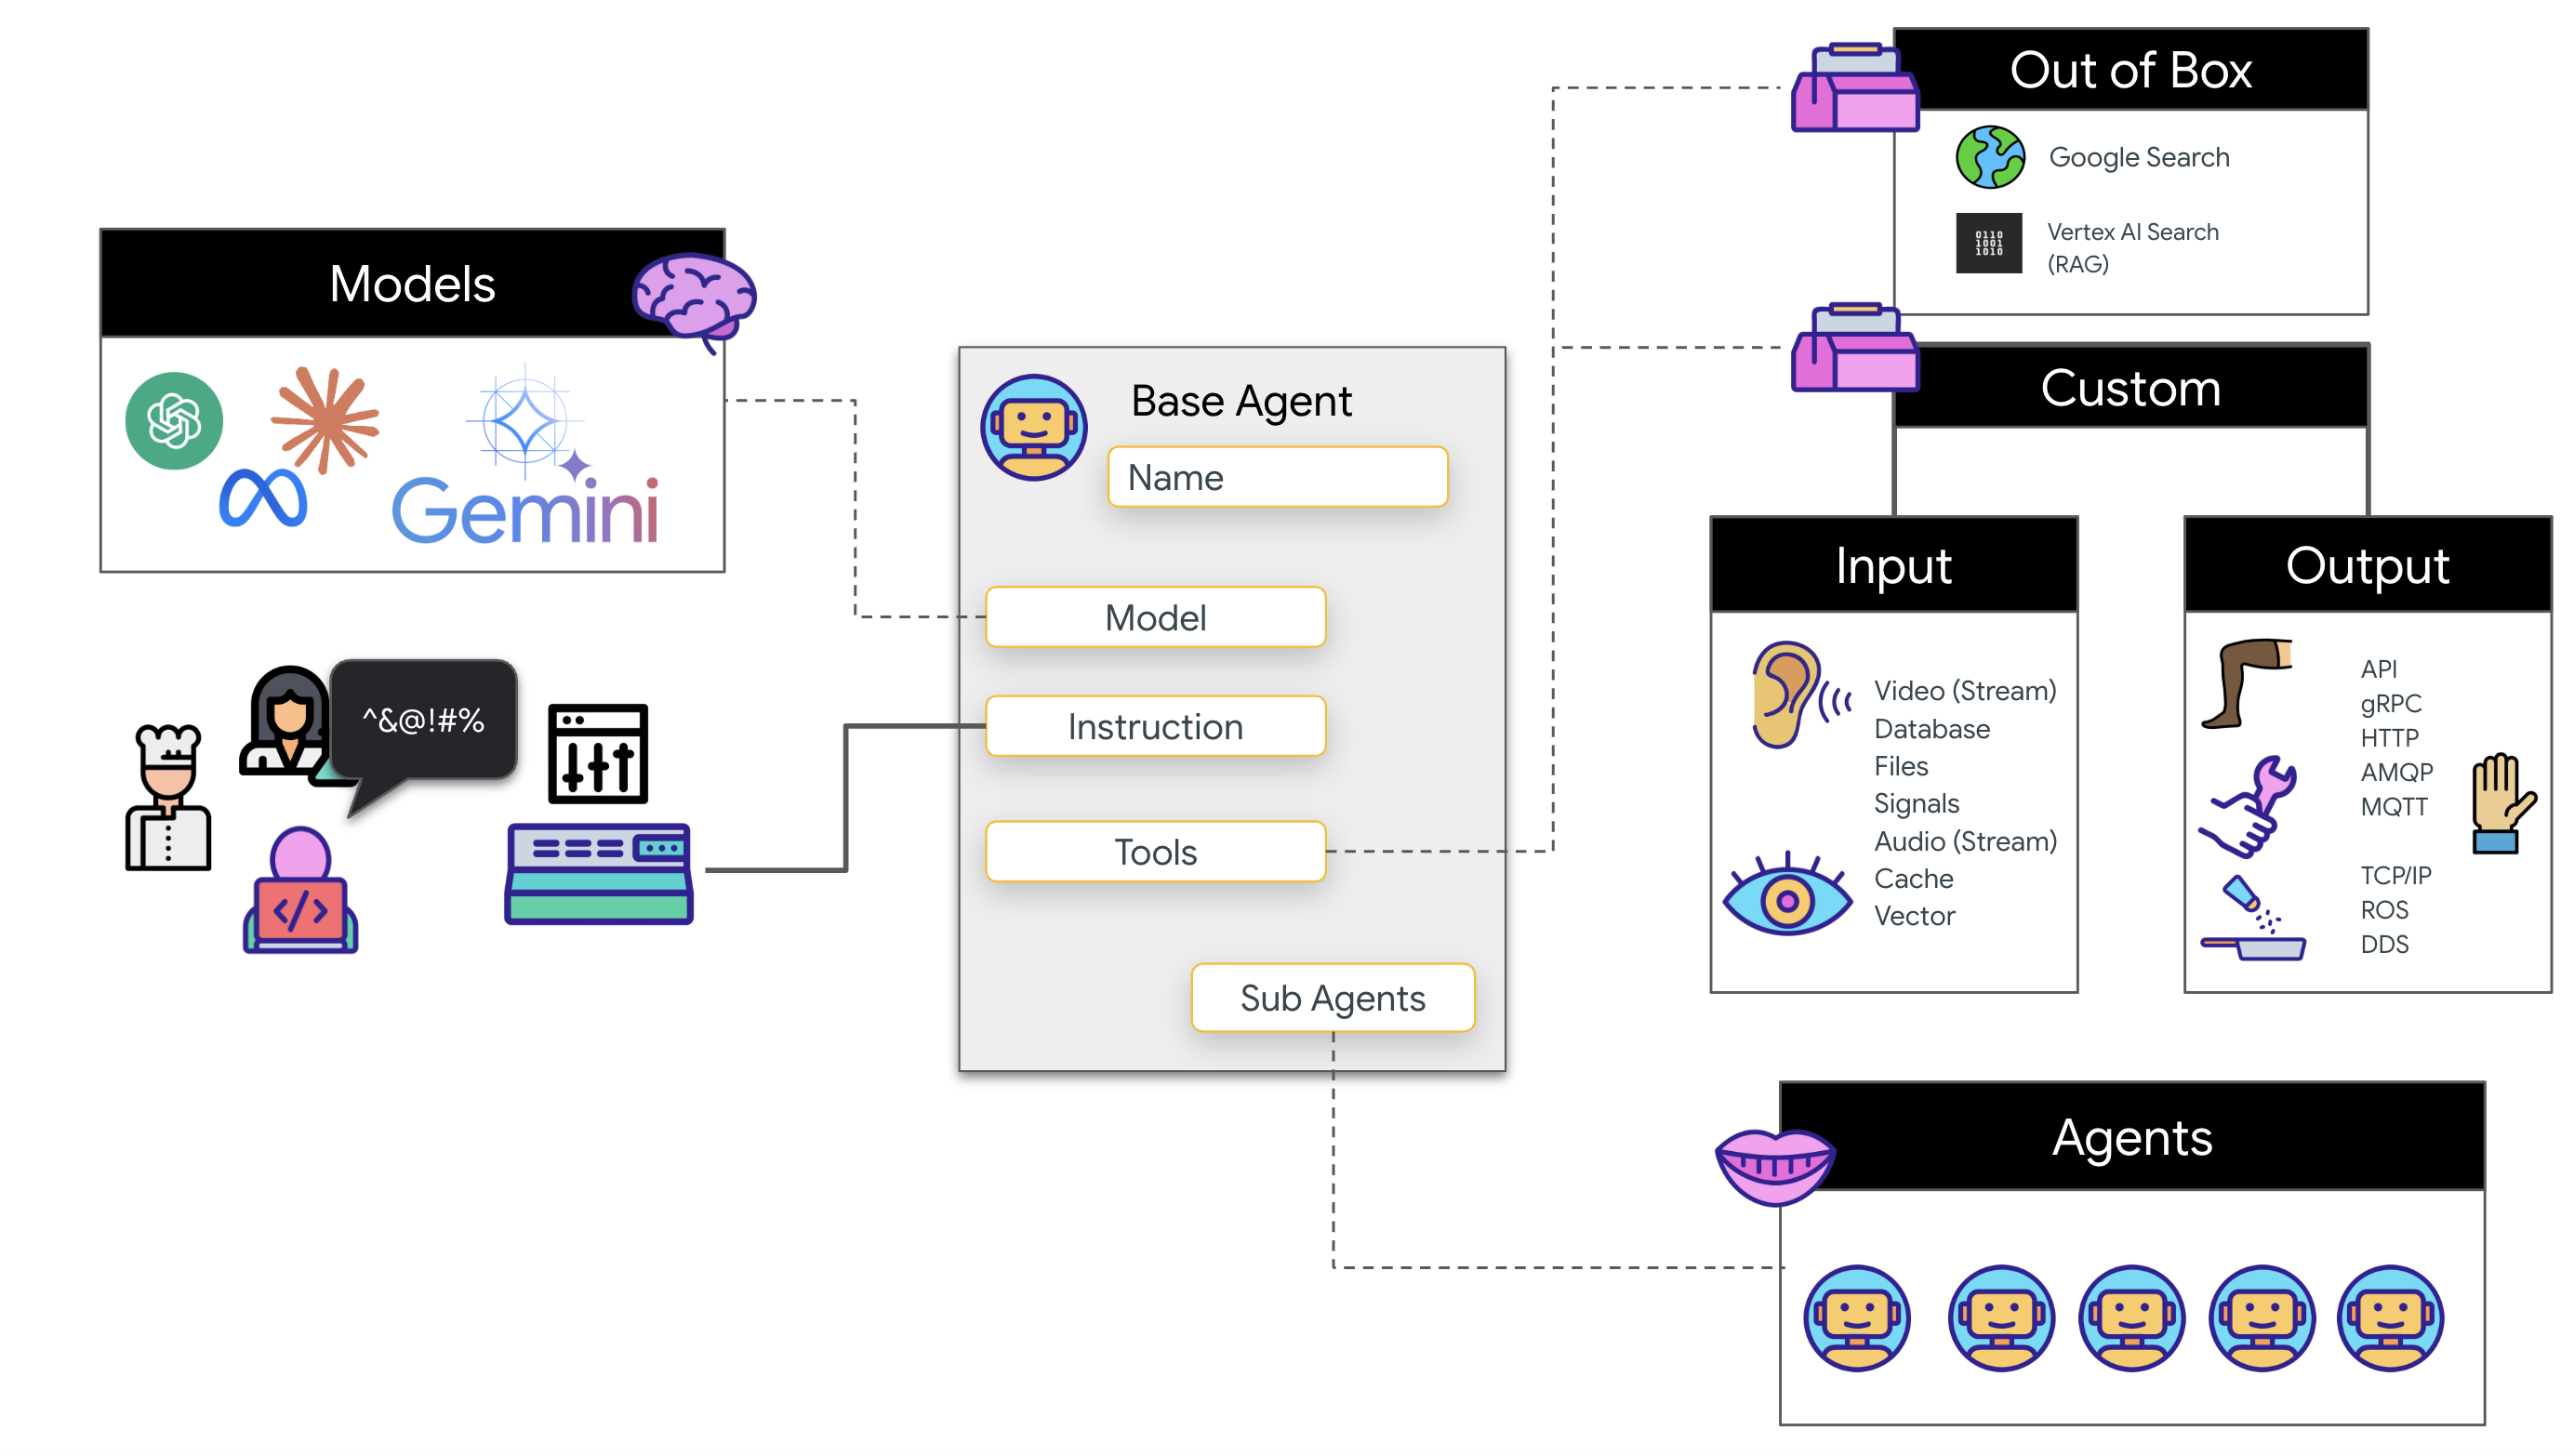

**このチュートリアルでは、以下を習得します。**

*   ✅ **ツールの定義と使用法:** エージェントに特定の能力（データの取得など）を付与する Python 関数（`tools`）を作成し、エージェントにそれらを効果的に使用する方法を指示します。
*   ✅ **エージェントの委任とコラボレーション:** 専用のサブエージェントを設計し、ユーザーのリクエストをチーム内の最も適切なエージェントに自動的にルーティング（`auto flow`）できるようにします。
*   ✅ **メモリのためのセッション状態:** `Session State` と `ToolContext` を利用して、エージェントが会話のターンをまたいで情報を記憶できるようにし、より文脈に沿ったインタラクションを実現します。
*   ✅ **コールバックによる安全ガードレール:** `before_model_callback` と `before_tool_callback` を実装して、事前定義されたルールに基づいてリクエスト/ツールの使用を検査、変更、またはブロックし、アプリケーションの安全性と制御を強化します。

**最終状態の期待:**

このチュートリアルを完了すると、機能的なマルチエージェント天気予報ボットシステムを構築できます。このシステムは、天気情報を提供するだけでなく、会話の丁寧なやり取りを処理し、最後に確認した都市を記憶し、ADK を使用して調整された定義済みの安全境界内で動作します。

**前提条件:**

*   ✅ **Pythonプログラミングの理解。**
*   ✅ **Vertex AI APIを使うための`roles/aiplatform.user` role**
*   ✅ **外部データ連携の実装する場合は Google Maps Platform(Geocoding API)と(Weather API)それぞれのAPIキー**
*   ✅ **Agent Engine にデプロイする場合は依存フィルを入れるためのCloud Storage Bucket**

---

**実行環境に関する注意:**

このチュートリアルは、Google Colab、Colab Enterprise、Jupyter ノートブックなどのインタラクティブなノートブック環境向けに構成されています。次の点に留意してください。

*   **非同期コードの実行:** ノートブック環境は、非同期コードを異なる方法で処理します。`await`（イベントループがすでに実行されている場合に適しております。ノートブックでは、すでにイベントループが実行されているので、これが一般的です）または `asyncio.run()`（スタンドアロンの `.py` スクリプトとして実行する場合や特定のノートブック設定で必要な場合が多い）を使用した例が表示されます。コードブロックは、両方のシナリオのガイダンスを提供します。
*   **手動ランナー/セッション設定:** 手順には、`Runner` および `SessionService` インスタンスを明示的に作成することが含まれます。このアプローチは、エージェントの実行ライフサイクル、セッション管理、および状態の永続化をきめ細かく制御できるため、示されています。

---

**エージェントチームを構築する準備はできましたか？始めましょう！**

---

## ステップ 0: 事前準備

In [ ]:
# @title 必要な依存ライブラリをインストール
%pip install "google-cloud-aiplatform[agent_engines,adk]==1.95.0" -q
%pip install google-adk==1.1.0  -q

# print("Installation complete.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.5/229.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.0/119.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.9/194.9 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.1/217.1 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 334.1/334.1 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# @title 必要な依存ライブラリをインポート
import os
from google.adk.agents import Agent
from google.adk.sessions import InMemorySessionService
from google.adk.runners import Runner


In [ ]:
# @title APIキーの設定

# Vertex AI API　使用設定
GOOGLE_CLOUD_PROJECT = "PLACE_HOLDER" # @param {type:"string"}
os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = "True"
os.environ["GOOGLE_CLOUD_PROJECT"] = GOOGLE_CLOUD_PROJECT
os.environ["GOOGLE_CLOUD_LOCATION"] = "us-central1"

# --- 重要：プレースホルダを実際のAPIキーに置き換えてください ---
# [オプション]
# Google Weather APIキー(https://developers.google.com/maps/documentation/weather/get-api-key?hl=ja)
GOOGLE_WEATHER_API_KEY="PLACE_HOLDER" # @param {type:"string"}
os.environ["GOOGLE_WEATHER_API_KEY"] = GOOGLE_WEATHER_API_KEY


# Google Maps APIキー(https://developers.google.com/maps/documentation/geocoding/get-api-key?hl=ja)
GOOGLE_MAPS_API_KEY="PLACE _HOLDER" # @param {type:"string"}
os.environ["GOOGLE_MAPS_API_KEY"] = GOOGLE_MAPS_API_KEY

# --- 使いやすくするためにモデル定数を定義します ---
DEFAULT_MODEL = "gemini-2.5-flash-preview-05-20"
LITE_MODEL = "gemini-2.0-flash-lite"

print("\n環境設定が完了しました。")


環境設定が完了しました。


In [ ]:
# @title Google Cloud ログイン (Colab環境の場合)
from google.colab import auth
auth.authenticate_user(project_id=GOOGLE_CLOUD_PROJECT)

In [ ]:
# @title Google Cloud ログイン (Workbenchやローカルマシンの場合)
!gcloud auth application-default login

---

## ステップ 1: 初めてのエージェント - 基本的な天気情報検索

まず、天気予報ボットの基本的なコンポーネントである、特定のタスク（天気情報の検索）を実行できる単一のエージェントを構築することから始めましょう。これには、2 つのコア要素の作成が含まれます。

1. **Tool:** エージェントに天気データを取得する*能力*を与える Python 関数。
2. **Agent:** ユーザーのリクエストを理解し、天気ツールを持っていることを認識し、いつ、どのように使用するかを決定する AI の「頭脳」。

---

###  1\. Toolの定義 (get_weather)

ADK では、Toolは、単なるテキスト生成を超えた具体的な機能をエージェントに与える構成要素です。これらは通常、API の呼び出し、データベースへのクエリ、計算の実行など、特定のアクションを実行する通常の Python 関数です。

最初のToolは、モックの天気予報を提供します。これにより、まだ外部APIキーを必要とせずに、エージェントの構造に集中できます。後で、このモック関数を実際の気象サービスを呼び出す関数に簡単に置き換えることができます。

**docstring は重要です！**
エージェントの LLM は、関数の docstring から以下の情報を取得します。

*  ツールが何をするか。
*  いつ使用するか。
*  どの引数が必要か（city: str）。
*  どの情報を返すか。
*  ベストプラクティス: ツールには、明確で、説明的で、正確な docstring を記述してください。これは、LLM がツールを正しく使用するために不可欠です。

In [ ]:
def get_weather(city: str) -> dict:
    """指定された都市の現在の天気予報を取得します。

    Args:
        city (str): 都市名（例：「ニューヨーク」、「ロンドン」、「東京」）。

    Returns:
        dict: 天気情報を含む辞書。
              'status' キー（'success' または 'error'）を含みます。
              'success' の場合、天気の詳細情報を持つ 'report' キーを含みます。
              'error' の場合、'error_message' キーを含みます。
    """
    print(f"--- ツール: get_weather が都市 {city} で呼び出されました ---") # ツールの実行をログに記録

    # モックの天気データ
    mock_weather_db = {
        "ニューヨーク": {"status": "success", "report": "ニューヨークの天気は晴れ、気温は25℃です。"},
        "ロンドン": {"status": "success", "report": "ロンドンは曇り、気温は15℃です。"},
        "東京": {"status": "success", "report": "東京は小雨、気温は18℃です。"},
    }

    if city in mock_weather_db:
        return mock_weather_db[city]
    else:
        return {"status": "error", "error_message": f"申し訳ありませんが、「{city}」の天気情報はありません。"}

# ツールの使用例（オプションのテスト）
print(get_weather("ニューヨーク"))
print(get_weather("パリ"))

--- ツール: get_weather が都市 ニューヨーク で呼び出されました ---
{'status': 'success', 'report': 'ニューヨークの天気は晴れ、気温は25℃です。'}
--- ツール: get_weather が都市 パリ で呼び出されました ---
{'status': 'error', 'error_message': '申し訳ありませんが、「パリ」の天気情報はありません。'}


### 2\. エージェントの定義 (`weather_agent`)

次に、**エージェント**自体を作成しましょう。ADK の `Agent` は、ユーザー、LLM、および利用可能なツール間のインタラクションを調整します。

いくつかの主要なパラメータで構成します。

* `name`: このエージェントの一意の識別子（例: "weather\_agent\_v1"）。
* `model`: 使用する LLM を指定します（例: `MODEL_GEMINI_2_0_FLASH`）。特定の Gemini モデルから始めます。
* `description`: エージェントの全体的な目的の簡潔な要約。これは、他のエージェントが *この* エージェントにタスクを委任するかどうかを決定する必要がある場合に後で重要になります。
* `instruction`: LLM の動作方法、ペルソナ、目標、特に割り当てられた `tools` を *いつ、どのように* 利用するかについての詳細なガイダンス。
* `tools`: エージェントが使用を許可されている実際の Python ツール関数を含むリスト（例: `[get_weather]`）。

**ベストプラクティス:**

* 明確で具体的な `instruction` プロンプトを提供してください。指示が詳細であるほど、LLM はその役割とツールの効果的な使用方法をよりよく理解できます。必要に応じてエラー処理について明示的に記述してください。

* 説明的な `name` と `description` の値を選択してください。これらは ADK によって内部的に使用され、自動委任（後で説明）などの機能に不可欠です。

In [ ]:
# 先に定義されたモデル定数のいずれかを使用

weather_agent = Agent(
    name="weather_agent_v1",
    model=DEFAULT_MODEL,
    description="特定の都市の天気情報を提供します。",
    instruction="あなたは親切な天気アシスタントです。"
                "ユーザーが特定の都市の天気を尋ねたら、"
                "「get_weather」ツールを使用して情報を見つけてください。"
                "ツールがエラーを返した場合は、丁重にユーザーに伝えてください。"
                "ツールが成功した場合は、天気予報を明確に提示してください。",
    tools=[get_weather],
)

print(f"エージェント「{weather_agent.name}」はモデル「{DEFAULT_MODEL}」を使用して作成されました。")

エージェント「weather_agent_v1」はモデル「gemini-2.5-flash-preview-05-20」を使用して作成されました。


###  3\.ランナーとセッションサービスの設定

会話を管理し、エージェントを実行するには、さらに 2 つのコンポーネントが必要です。

* `SessionService`: さまざまなユーザーとセッションの会話履歴と状態を管理する責任があります。`InMemorySessionService` は、すべてをメモリに保存する単純な実装であり、テストや単純なアプリケーションに適しています。交換されたメッセージを追跡します。ステップ 4 で状態の永続化について詳しく説明します。
* `Runner`: ユーザー入力を処理し、エージェントを呼び出し、全体的なフローを管理するエンジンです。`SessionService` を使用して会話履歴を永続化および取得します。

In [ ]:
# --- セッション管理 ---
# 主要概念: SessionService は会話履歴と状態を保存します。
# InMemorySessionService はこのチュートリアル用のシンプルで非永続的なストレージです。
session_service = InMemorySessionService()

# 対話コンテキストを識別するための定数を定義します
APP_NAME = "weather_tutorial_app"
USER_ID = "user_1"
SESSION_ID = "session_001" # 簡単にするために固定IDを使用

# 会話が行われる特定のセッションを作成します
session = await session_service.create_session(
        app_name=APP_NAME,
        user_id=USER_ID,
        session_id=SESSION_ID
    )
print(f"セッションが作成されました: App='{APP_NAME}', User='{USER_ID}', Session='{SESSION_ID}'")

# 主要概念: Runner はエージェントの実行ループを調整します。
runner = Runner(
    agent=weather_agent, # 実行したいエージェント
    app_name=APP_NAME,   # 実行を私たちのアプリに関連付けます
    session_service=session_service # 私たちのセッションマネージャーを使用します
)
print(f"エージェント「{runner.agent.name}」用のランナーが作成されました。")

セッションが作成されました: App='weather_tutorial_app', User='user_1', Session='session_001'
エージェント「weather_agent_v1」用のランナーが作成されました。


### 4\. エージェントとの対話（メッセージの送信)

エージェント、ツール、ランナー、セッションサービスが設定されたので、最初のメッセージを送信してエージェントと対話する準備が整いました。

`runner.send_message()` 関数は、エージェントとの通信の中心です。主な引数は次のとおりです。

* `agent`: リクエストを処理するエージェント（この場合は `weather_agent`）。
* `message`: ユーザーが送信する実際のテキスト。
* `session_id` (オプション): 会話を一意に識別する文字列。指定しない場合、ランナーは通常、新しいセッションを作成するか、デフォルトのセッションを使用します。セッション ID を明示的に提供すると、特定の会話を追跡し、後で再開できます。
* `tools_context` (オプション): ツールの実行中に情報を渡したり、エージェントの呼び出し間で状態を維持したりするために使用できるディクショナリ。これについては、ステップ 4 で詳しく説明します。

**非同期実行に関する注意:**

ADK は非同期操作に大きく依存しており、特に LLM や外部ツールとの対話時に効率的です。Jupyter ノートブック（または既に実行中のイベントループを持つその他の環境）で作業している場合、通常、`await runner.send_message(...)` を使用して非同期呼び出しを直接待機できます。

ただし、標準の Python スクリプトから実行している場合、またはノートブックのイベントループが期待どおりに動作していない場合は、`asyncio.run(runner.send_message(...))` を使用して非同期関数を実行する必要があります。

提供されているコードスニペットには、両方のシナリオのコメントが含まれています。状況に合わせて適切な行のコメントを解除してください。このチュートリアルの残りの部分では、簡潔にするために `await` バージョンを主に表示しますが、原則は同じです。

In [ ]:
from google.genai import types # メッセージの Content/Parts を作成するため

async def call_agent_async(query: str, runner, user_id, session_id):
  """エージェントにクエリを送信し、最終応答を表示します。"""
  print(f"\n>>> ユーザーの質問: {query}")

  # ユーザーのメッセージをADK形式で準備します
  content = types.Content(role='user', parts=[types.Part(text=query)])

  final_response_text = "エージェントは最終応答を生成しませんでした。" # デフォルト

  # 主要概念: run_async はエージェントのロジックを実行し、イベントを生成します。
  # 最終的な回答を見つけるためにイベントを反復処理します。
  async for event in runner.run_async(user_id=user_id, session_id=session_id, new_message=content):
      # 実行中の *すべて* のイベントを確認するには、以下の行のコメントを解除できます
      # print(f"  [イベント] 作成者: {event.author}, タイプ: {type(event).__name__}, 最終: {event.is_final_response()}, 内容: {event.content}")

      # 主要概念: is_final_response() はターンの最終メッセージを示します。
      if event.is_final_response():
          if event.content and event.content.parts:
             # 最初の部分にテキスト応答があると仮定します
             final_response_text = event.content.parts[0].text
          elif event.actions and event.actions.escalate: # 潜在的なエラー/エスカレーションを処理します
             final_response_text = f"エージェントがエスカレーションしました: {event.error_message or '特定のエラーメッセージはありません。'}"
          # 必要に応じて、ここに追加のチェックを追加します（例：特定のエラーコード）
          break # 最終応答が見つかったらイベントの処理を停止します

  print(f"<<< エージェントの応答: {final_response_text}")

### 5\. テストしてみましょう！

いくつかのメッセージを送信して、`weather_agent` がどのように応答するかを確認します。

*   「ニューヨークの天気は？」(ツールが成功するはずです)
*   「パリの天気は？」(ツールが存在しない都市のため、エラーを返すはずです)
*   「こんにちは」(ツールを使用するようにはトリガーされないはずです)

各応答で何が起こるかに注目してください。

*   LLM がユーザーの意図をどのように解釈するか。
*   `get_weather` ツールが呼び出されたかどうか (サーバーログ/出力で `--- Tool: get_weather called...` を探してください)。
*   エージェントがツールからの情報 (またはエラーメッセージ) をどのように最終的な応答に組み込むか。

In [ ]:
# 対話ヘルパーを await するために非同期関数が必要です
async def run_conversation():
    await call_agent_async("ロンドンの天気はどうですか？",
                                       runner=runner,
                                       user_id=USER_ID,
                                       session_id=SESSION_ID)

    await call_agent_async("パリはどうですか？",
                                       runner=runner,
                                       user_id=USER_ID,
                                       session_id=SESSION_ID) # ツールのエラーメッセージを想定しています

    await call_agent_async("ニューヨークの天気を教えてください",
                                       runner=runner,
                                       user_id=USER_ID,
                                       session_id=SESSION_ID)

await run_conversation()


>>> ユーザーの質問: ロンドンの天気はどうですか？


--- ツール: get_weather が都市 ロンドン で呼び出されました ---
<<< エージェントの応答: ロンドンは曇りで、気温は15℃です。

>>> ユーザーの質問: パリはどうですか？


--- ツール: get_weather が都市 パリ で呼び出されました ---
<<< エージェントの応答: 申し訳ありませんが、「パリ」の天気情報はありません。

>>> ユーザーの質問: ニューヨークの天気を教えてください


--- ツール: get_weather が都市 ニューヨーク で呼び出されました ---
<<< エージェントの応答: ニューヨークの天気は晴れ、気温は25℃です。


---

おめでとうございます！最初の ADK エージェントの構築と対話に成功しました。エージェントはユーザーのリクエストを理解し、ツールを使用して情報を見つけ、ツールの結果に基づいて適切に応答します。
次のステップでは、このエージェントを強化する基盤となる言語モデルを簡単に切り替える方法を探ります。


## [オプション]： 外部データと連携 (OpenAPI Tool, MCP Toolを使用)

これまでのステップでは、エージェントの内部ツールやコールバックを中心に扱ってきました。このステップでは、ADK の OpenAPI Toolと MCP Toolを使用して、外部のデータと連携する方法を探ります。

OpenAPI Specification (以前は Swagger と呼ばれていました) は、REST API を記述するための標準的な方法です。ADK はこれらの仕様を解析し、API の各エンドポイントに対応するツールを自動的に生成できます。これにより、各 API 呼び出しを手動でツールとして定義する手間が省けます。

この例では、Google Maps Weather API のドキュメントを参考に、簡略化された概念的な OpenAPI 仕様を作成し、それを使用して ADK ツールを生成し、エージェントに統合する方法を示します。

**このステップで行うこと:**

1.  天気の現在状況と時間別予報を取得するための、簡略化された OpenAPI 仕様を定義します。
2.  ADK の `OpenAPIToolset` を使用して、この仕様からツールを生成します。
3.  これらの生成されたツールを使用するように新しいエージェントを設定します。
4.  エージェントがこれらのツールを呼び出して (シミュレートされた) API リクエストを行う方法を示します。

**注意:** ここで定義する OpenAPI 仕様は、デモンストレーション目的の簡略化された例であり、Google Maps Weather API の完全な機能や認証要件を網羅するものではありません。実際の API を使用する場合は、公式の仕様 (利用可能な場合) と認証の詳細を参照する必要があります。

### 1. OpenAPI Spec からツールを生成する

ADK の `OpenAPIToolset` クラスは、OpenAPI 仕様文字列 (JSON または YAML) または Python 辞書を受け取り、それを解析して、API の各操作 (エンドポイント) に対して `RestApiTool` インスタンスのリストを生成します。

これらのツールは、LLM が自然言語の指示に基づいて API を呼び出すために必要なすべての情報 (説明、パラメータ、期待される応答など) をカプセル化します。

In [ ]:
# この仕様は、デモンストレーション目的で手動作成されたもので、実際のAPIエンドポイントを対象としています。
openapi_spec_google_weather_api_str = """
{
  "openapi": "3.0.0",
  "info": {
    "title": "Simplified Google Weather API",
    "version": "v1",
    "description": "A simplified, manually-created OpenAPI spec for interacting with select Google Maps Weather API functionalities."
  },
  "servers": [
    {
      "url": "https://weather.googleapis.com/v1",
      "description": "Google Maps Weather API Server"
    }
  ],
  "paths": {
    "/currentConditions:lookup": {
      "get": {
        "operationId": "getCurrentWeatherConditions",
        "summary": "Get the current weather conditions for a location using Google Weather API.",
        "description": "Fetches real-time weather data including temperature, wind, and precipitation for the specified latitude and longitude. Requires an API key.",
        "parameters": [
          {
            "name": "location.latitude",
            "in": "query",
            "required": true,
            "description": "The latitude of the location.",
            "schema": {
              "type": "number",
              "format": "double"
            }
          },
          {
            "name": "location.longitude",
            "in": "query",
            "required": true,
            "description": "The longitude of the location.",
            "schema": {
              "type": "number",
              "format": "double"
            }
          },
          {
            "name": "key",
            "in": "query",
            "required": true,
            "description": "Your Google Cloud API key.",
            "schema": {
              "type": "string"
            }
          }
        ],
        "responses": {
          "200": {
            "description": "Successful response with current weather conditions.",
            "content": {
              "application/json": {
                "schema": {
                  "type": "object",
                  "properties": {
                    "dateTime": { "type": "string", "format": "date-time"},
                    "temperature": { "type": "object", "properties": {"value": {"type": "number"}, "unit": {"type": "string"}}},
                    "wind": { "type": "object", "properties": {"speed": {"type": "number"}, "direction": {"type": "number"}}},
                    "shortDescription": { "type": "string" }
                  }
                }
              }
            }
          },
          "400": { "description": "Invalid request parameters." },
          "403": { "description": "Forbidden - API key missing, invalid, or Weather API not enabled." }
        }
      }
    }
  },
  "components": {
    "securitySchemes": {
      "ApiKeyAuth": {
        "in": "query",
        "name": "key",
        "required": true,
        "description": "Your Google Cloud API key.",
        "schema": { "type": "string" }
      }
    }
  }
}
"""

print("✅ Simplified Google Weather API OpenAPI spec string defined, targeting actual API endpoint.")

✅ Simplified Google Weather API OpenAPI spec string defined, targeting actual API endpoint.


In [ ]:
from google.adk.tools.openapi_tool.openapi_spec_parser.openapi_toolset import OpenAPIToolset
from google.adk.tools.openapi_tool.auth.auth_helpers import token_to_scheme_credential
from google.adk.tools.mcp_tool.mcp_toolset import MCPToolset, StdioServerParameters
import os

# --- OpenAPIツールセットの作成 ---
google_weather_toolset = None

try:
    # Retrieve the API key from environment variable for security
    google_api_key = os.environ.get("GOOGLE_WEATHER_API_KEY")
    if not google_api_key:
        raise ValueError("GOOGLE_WEATHER_API_KEY environment variable not set.")

    # Create auth scheme and credential using the helper function
    # This call is synchronous, and its return values are used directly.
    auth_scheme, auth_credential = token_to_scheme_credential(
        "apikey",  # Authentication type
        "query",   # API key location (query parameter)
        "key",     # Parameter name in the API
        google_api_key  # The actual API key value
    )

    google_weather_toolset = OpenAPIToolset(
        spec_str=openapi_spec_google_weather_api_str, # Use the new spec string
        spec_str_type="json",
        auth_scheme=auth_scheme,        # Use the scheme directly
        auth_credential=auth_credential # Use the credential directly
    )
    generated_google_weather_api_tools = await google_weather_toolset.get_tools()
    print(f"✅ OpenAPI 仕様から {len(generated_google_weather_api_tools)} 個のツールが生成されました:")
    for tool in generated_google_weather_api_tools:
        print(f"  - ツール名: '{tool.name}', 説明: {tool.description[:80]}...")

except ValueError as ve:
    print(f"❌ OpenAPIToolset の作成中の検証エラー: {ve}")
except Exception as e:
    print(f"❌ OpenAPIToolset の作成中の予期しないエラー: {e}")

if not google_weather_toolset:
    print("⚠️ ツールが生成されませんでした。エージェントの作成/テストはスキップされます。")


✅ OpenAPI 仕様から 1 個のツールが生成されました:
  - ツール名: 'get_current_weather_conditions', 説明: Fetches real-time weather data including temperature, wind, and precipitation fo...


### Google Maps MCP ツールセットの作成

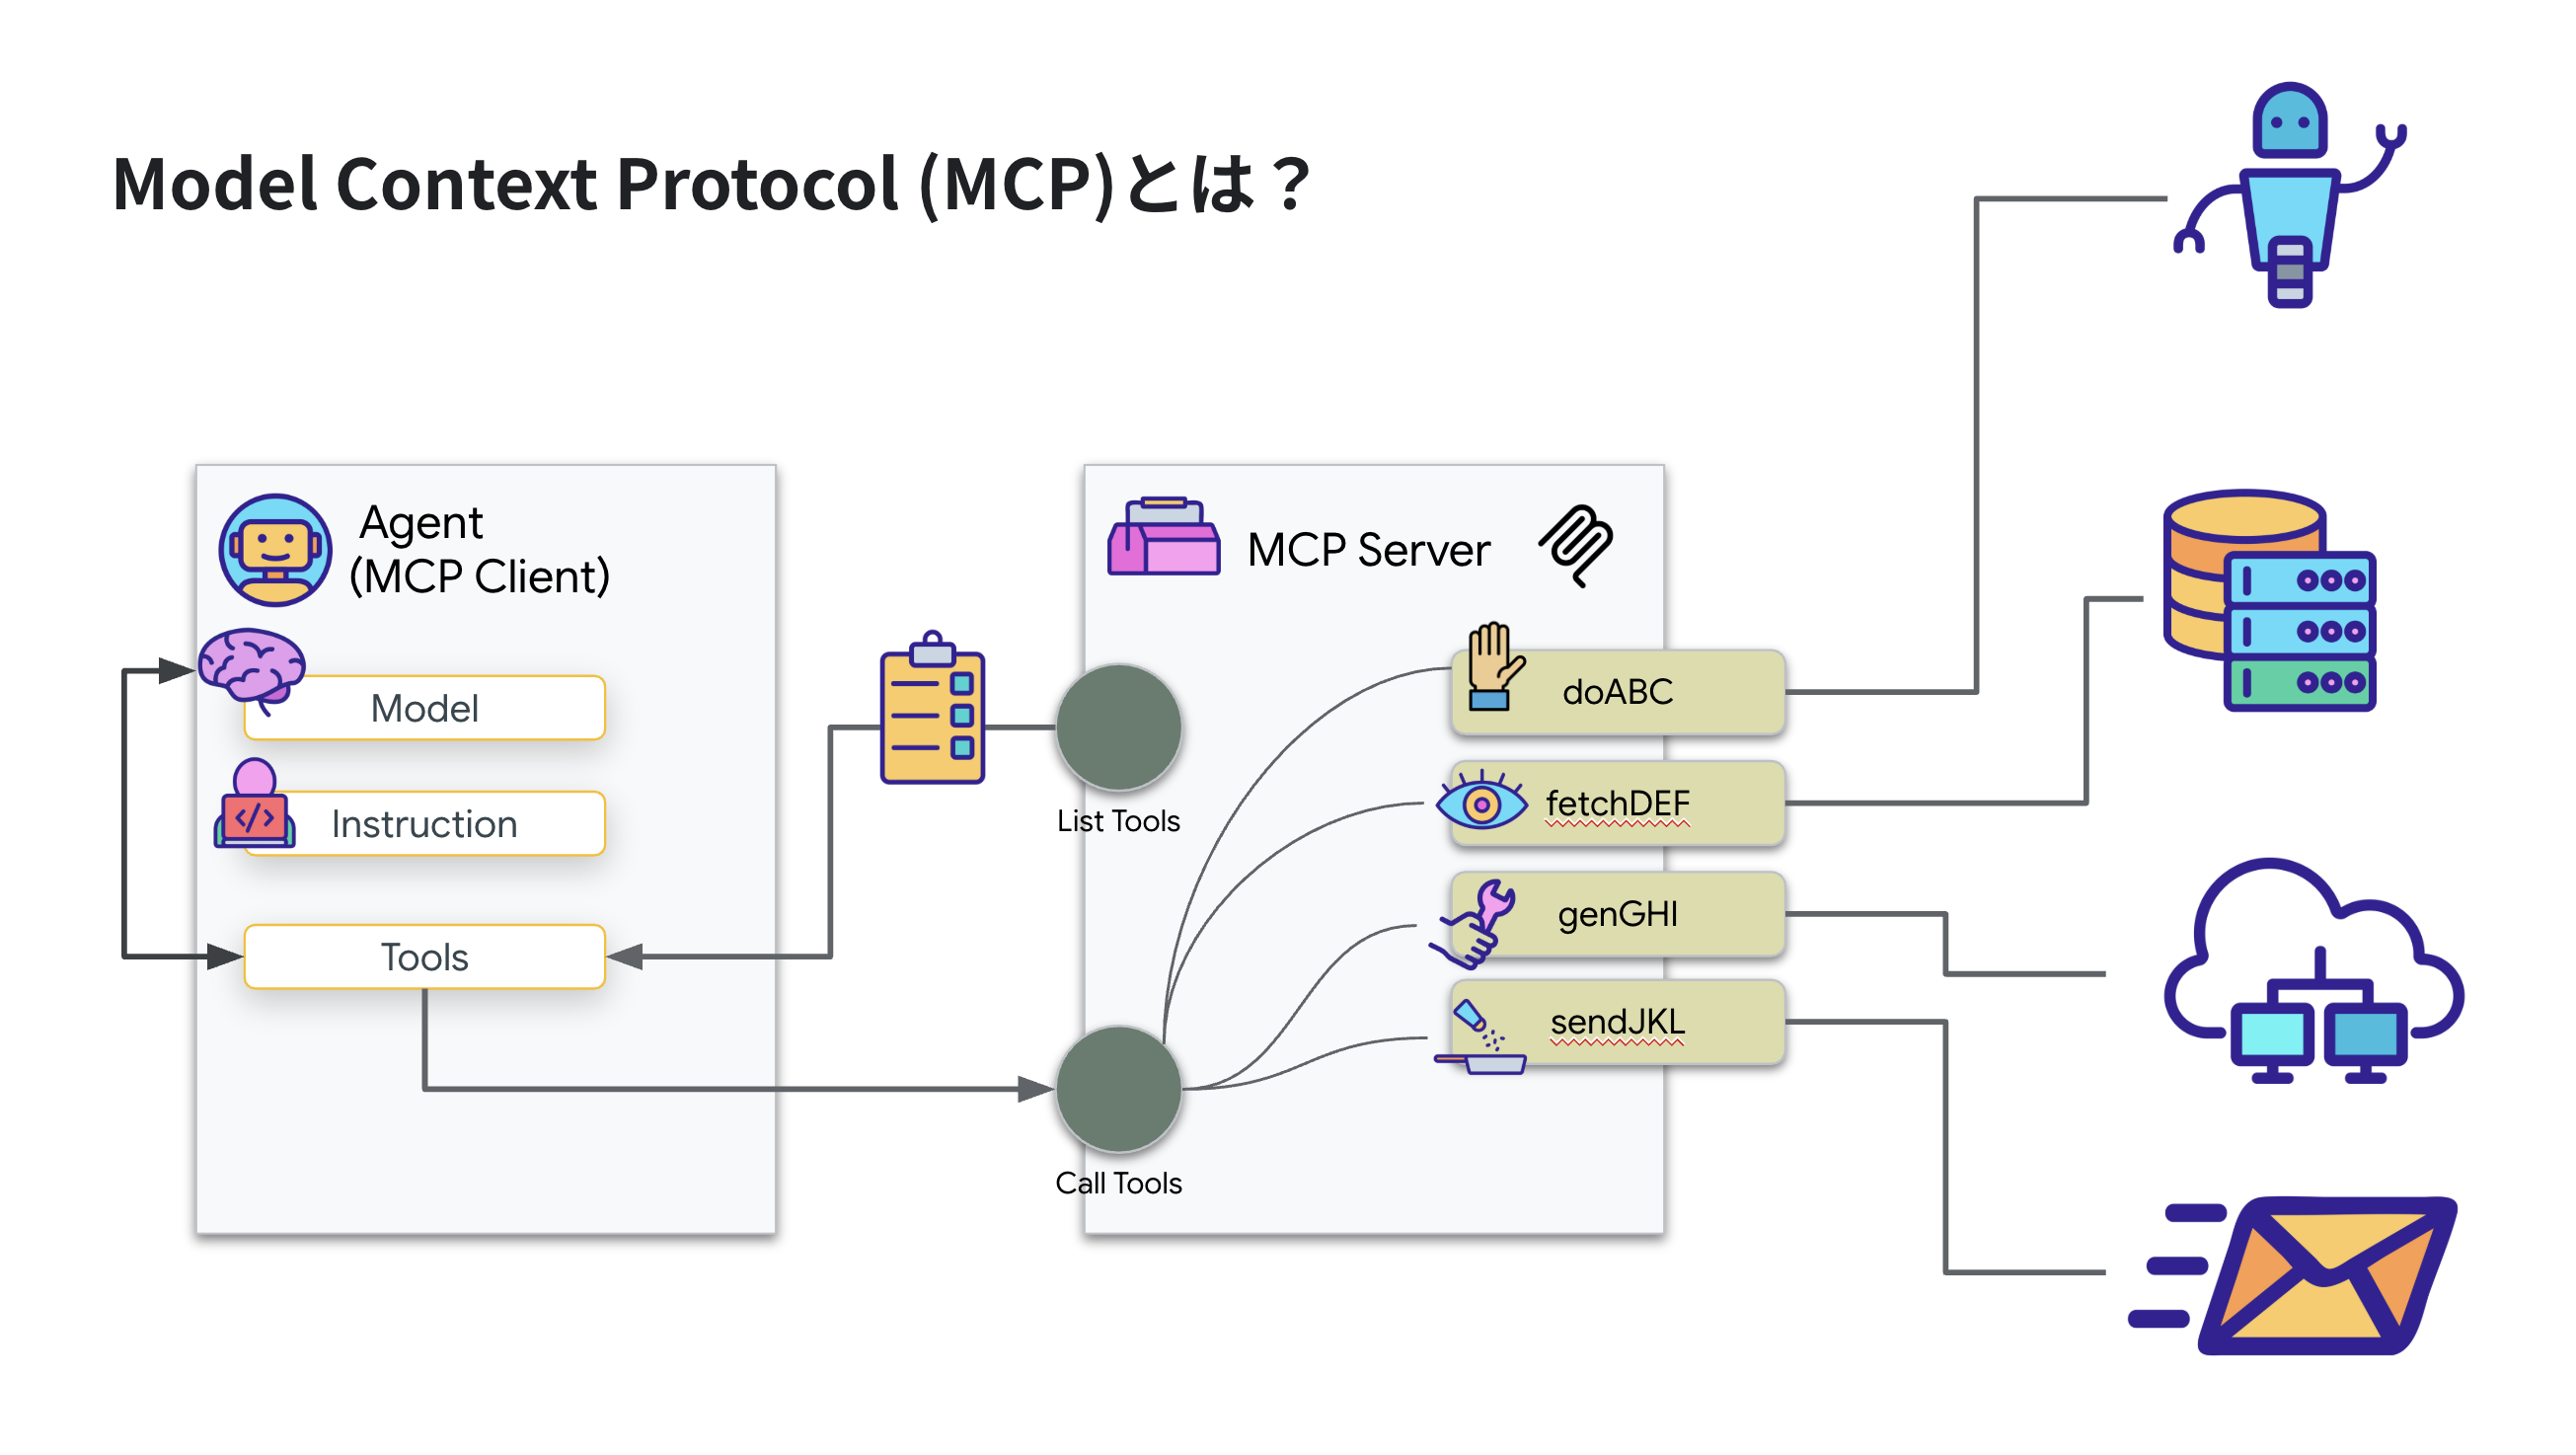

> ⚠️ **以下のセルはColab環境でのみ実行してください**
>
> このコードは、Google Colabの環境で、標準出力（sys.stdout）や標準エラー出力（sys.stderr）が持つべきfileno()というメソッドが存在しない問題を解決するための「パッチ（修正プログラム）」です。

In [ ]:
# --- Colab stdout/stderr lack a working fileno() – patch once -------------
import sys, io, ipykernel.iostream

def _safe_fileno(self):
    """
    Return a real FD so libraries that expect fileno() keep working.
    • Try the original copy kept by Colab (if present).
    • Fallback to 1 (stdout) when all else fails.
    """
    if hasattr(self, "_original_stdstream_copy"):
        return self._original_stdstream_copy.fileno()
    return 1                   # 1 = stdout  (2 would be stderr)

# Patch the current OutStream class (used for both stdout and stderr)
ipykernel.iostream.OutStream.fileno = _safe_fileno

# If stdout / stderr have already been instantiated, patch them too
for stream in (sys.stdout, sys.stderr):
    if not hasattr(stream, "fileno") or isinstance(stream, ipykernel.iostream.OutStream):
        stream.fileno = _safe_fileno.__get__(stream, type(stream))
# --------------------------------------------------------------------------


> ⚠️ **Colab以外では以下のセルからお進みください**

In [ ]:
# Google Maps MCP ツールセットを作成して、都市名から緯度と経度を取得します
from mcp import StdioServerParameters
google_maps_mcp_toolset = None
from google.adk.tools.mcp_tool.mcp_toolset import MCPToolset

try:
    google_maps_api_key = os.environ.get("GOOGLE_MAPS_API_KEY")
    if not google_maps_api_key:
        raise ValueError("GOOGLE_MAPS_API_KEY environment variable not set.")

    # Google Maps MCP ツールセットを作成
    google_maps_mcp_toolset = MCPToolset(
        connection_params=StdioServerParameters(
            command='npx',
            args=[
                "-y",
                "@modelcontextprotocol/server-google-maps",
            ],
            # MCP サーバーに API キーを環境変数として渡します
            env={
                "GOOGLE_MAPS_API_KEY": google_maps_api_key
            }
        )
    )
    print("✅ Google Maps MCP ツールセットが作成されました。")
except Exception as e:
    print(f"❌ Google Maps MCP ツールセットの作成中にエラーが発生しました: {e}")


✅ Google Maps MCP ツールセットが作成されました。


### 2. 生成されたツールをエージェントに統合する

`OpenAPIToolset` からツールのリストを取得したら、それらを ADK `Agent` の `tools` パラメータに渡すことができます。エージェントの指示 (`instruction`) も更新して、新しい API 機能と使用できるツールの名前 (例: `get_current_conditions`、`get_hourly_forecast`) をエージェントに通知することが重要です。

In [ ]:
from google.adk.agents import Agent
openapi_google_weather_agent = None

if google_weather_toolset and google_maps_mcp_toolset:
    openapi_google_weather_agent = Agent(
        name="google_weather_api_assistant",
        model=DEFAULT_MODEL,
        tools=[google_weather_toolset,  google_maps_mcp_toolset],
        instruction=f"""あなたは、Google Weather API と Google Maps を連携する天気予報アシスタントです。
        ユーザーが都市の天気について尋ねた場合（例：「ロンドンの天気は？」）、次の2つのステップで対応してください：

        1. まず、Maps toolsを使用して、都市名から緯度と経度の座標を取得します。
           例えば、ユーザーが「ロンドンの天気は？」と尋ねた場合、Maps toolsを使用して
           「London」の緯度と経度を取得します。

        2. 次に、取得した緯度と経度を使用して、Weather toolsを呼び出し、
           その場所の現在の天気情報を取得します。

        ツールはAPIキーを自動的に処理します。

        利用可能なツール:
        - Maps tools（都市名から座標を取得）
        - Weather tools: {', '.join([t.name for t in generated_google_weather_api_tools])}""",
        description="Maps tools と Weather tools を使用して、都市名から天気情報を提供します。"
    )
    print(f"✅'{openapi_google_weather_agent.name}'エージェントがGoogle MapsツールとGoogle Weatherツールで作成されました。")
else:
    print("⚠️ 必要なツールが生成されなかったため、エージェントの作成をスキップします。")


✅'google_weather_api_assistant'エージェントがGoogle MapsツールとGoogle Weatherツールで作成されました。


### Google Weather API エージェント用のランナーとセッションの設定

In [ ]:
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
import uuid

runner_google_weather = None
session_service_google_weather = None
SESSION_ID_GOOGLE_WEATHER = f"session_google_weather_{uuid.uuid4()}"
USER_ID_GOOGLE_WEATHER = "user_google_weather_1"
APP_NAME_GOOGLE_WEATHER = "google_weather_tutorial_app"

if openapi_google_weather_agent:
    session_service_google_weather = InMemorySessionService()
    runner_google_weather = Runner(
        agent=openapi_google_weather_agent,
        app_name=APP_NAME_GOOGLE_WEATHER,
        session_service=session_service_google_weather
    )
    session_google_weather = await session_service_google_weather.create_session(
        app_name=APP_NAME_GOOGLE_WEATHER,
        user_id=USER_ID_GOOGLE_WEATHER,
        session_id=SESSION_ID_GOOGLE_WEATHER
    )
    print(f"✅ Google Weather API エージェント用のランナーとセッション (ID: {SESSION_ID_GOOGLE_WEATHER}) が作成されました。")
else:
    print("⚠️ エージェントが作成されなかったため、ランナーとセッションの設定をスキップします。")


✅ Google Weather API エージェント用のランナーとセッション (ID: session_google_weather_40744844-e413-444e-add0-67ee74db2e2a) が作成されました。


### 3. エージェントとの対話 (シミュレーション)

エージェントが設定されたので、メッセージを送信して、OpenAPI 仕様から生成されたツールを使用するように指示できます。

この例では、OpenAPI 仕様で定義された `servers` URL (`https://mock-weather-api.example.com`) は実際には存在しないため、実際の HTTP リクエストは失敗します (または、ADK がリクエストを試行する前に停止する可能性があります)。重要なのは、エージェントがユーザーのクエリに基づいて正しいツール (例: `get_current_conditions`) を選択し、OpenAPI 仕様から推測された正しいパラメータ (例: `latitude`, `longitude`, `apiKey`) で呼び出そうとすることです。

`call_agent_async` 関数 (以前のステップで定義) を使用して対話します。

In [ ]:
async def run_google_weather_api_conversation():
    if not runner_google_weather or not openapi_google_weather_agent:
        print("⚠️ Google Weather API エージェントまたはランナーが利用できないため、会話をスキップします。")
        return

    print("\\n--- Google Weather API エージェントとの対話テスト ---")

    # 都市名から天気を取得するテスト - Google Maps MCP を使用して座標を取得し、その後天気を取得します
    await call_agent_async(
        query="ロンドンの天気はどうですか？",
        runner=runner_google_weather,
        user_id=USER_ID_GOOGLE_WEATHER,
        session_id=SESSION_ID_GOOGLE_WEATHER
    )

    # 別の都市でもテスト
    await call_agent_async(
        query="ニューヨークの現在の天気を教えてください。",
        runner=runner_google_weather,
        user_id=USER_ID_GOOGLE_WEATHER,
        session_id=SESSION_ID_GOOGLE_WEATHER
    )

if 'call_agent_async' in globals() and callable(call_agent_async):
    if openapi_google_weather_agent and runner_google_weather:
        print("Google Weather API エージェントとの会話を実行しています...")
        try:
            await run_google_weather_api_conversation()
        except RuntimeError as e:
            if "asyncio.run() cannot be called from a running event loop" in str(e):
                print("\\n注意：イベントループが既に実行されているようです。")
            else:
                raise e
    else:
        print("⚠️ Google Weather API エージェントまたはランナーがセットアップされていないため、会話の実行をスキップします。")
else:
    print("⚠️ `call_agent_async` 関数が定義されていません。このセルを実行する前に、以前のステップからコピーしてください。")

Google Weather API エージェントとの会話を実行しています...
\n--- Google Weather API エージェントとの対話テスト ---

>>> ユーザーの質問: ロンドンの天気はどうですか？


<<< エージェントの応答: ロンドンの現在の天気は、気温18.5℃、体感温度21.6℃です。ほとんど曇りで、湿度77%です。風は南西から14km/hで吹いており、突風は27km/hです。降水確率は10%（雨）で、視程は16km、UV指数は0です。

>>> ユーザーの質問: ニューヨークの現在の天気を教えてください。


<<< エージェントの応答: ニューヨークの現在の天気は、気温19.4℃、体感温度24.6℃です。曇りで、湿度は73%です。風は西から3km/hで吹いており、突風は9km/hです。降水確率は10%（雨）で、視程は16km、UV指数は1です。


### まとめ

このステップでは、次のことを学びました。
-   外部APIの機能を記述する概念的なOpenAPI仕様を作成する方法。
-   ADKの`OpenAPIToolset`を使用して、その仕様から`RestApiTool`インスタンスを自動的に生成する方法。
-   これらの生成されたツールをADKエージェントに統合し、エージェントにそれらの使用方法を指示する方法。

OpenAPIツールは、エージェントが広範な外部サービスと対話できるようにするための強力な方法であり、各APIエンドポイントを手動でコーディングする複雑さを大幅に軽減します。実際のAPIを使用する場合は、認証、エラー処理、およびAPIのレート制限を適切に処理する必要があることに注意してください。

## ステップ 2：エージェントチームの構築 - 挨拶と別れの委任
ステップ1では、天気予報の検索のみに焦点を当てた単一のエージェントを構築し、実験しました。特定のタスクには効果的ですが、実際のアプリケーションでは、より多様なユーザーインタラクションを処理することがよくあります。単一の天気エージェントにツールや複雑な指示を追加し続けることもできますが、これはすぐに管理が難しくなり、効率も低下します。
より堅牢なアプローチは、**エージェントチーム**を構築することです。これには次のものが含まれます。
1. 特定の機能（例：天気用、挨拶用、計算用など）に合わせて設計された、複数の**特化型エージェント**を作成します。
2. 最初のユーザーリクエストを受信する**ルートエージェント**（またはオーケストレーター）を指定します。
3. ユーザーの意図に基づいて、ルートエージェントがリクエストを最も適切な特化型サブエージェントに**委任**できるようにします。

**なぜエージェントチームを構築するのか？**
- **モジュール性:** 個々のエージェントの開発、テスト、保守が容易になります。
- **専門化:** 各エージェントを特定のタスクに合わせて（指示、モデルの選択など）微調整できます。
- **スケーラビリティ:** 新しいエージェントを追加することで、新しい機能の追加が簡単になります。
- **効率性:** （挨拶のような）より単純なタスクには、より単純で安価なモデルを使用できる可能性があります。

**このステップでは、次のことを行います。**
1. 挨拶（）と別れ（）を処理するための単純なツールを定義します。 `say_hello``say_goodbye`
2. 2つの新しい特化型サブエージェントを作成します：`greeting_agent`と`farewell_agent`。
3. メインの天気エージェント（`weather_agent_v2`）を更新して、**ルートエージェント**として機能するようにします。
4. ルートエージェントをサブエージェントで構成し、**自動委任**を有効にします。
5. ルートエージェントにさまざまな種類のリクエストを送信して、委任フローをテストします。


### 1\. サブエージェント用のツールを定義する

まず、新しいスペシャリストエージェントのツールとして機能する単純なPython関数を作成しましょう。明確なdocstringは、それらを使用するエージェントにとって不可欠であることを忘れないでください


In [ ]:
def say_hello(name: str) -> str:
    """名前を指定して簡単な挨拶を提供します。

    Args:
        name (str, optional): 挨拶する相手の名前

    Returns:
        str: 友好的な挨拶メッセージ。
    """
    print(f"--- ツール: say_hello が名前: {name} で呼び出されました ---")
    if name:
      return f"こんにちは、{name}さん！"
    else:
      return "こんにちは！"

def say_goodbye() -> str:
    """会話を締めくくるための簡単な別れのメッセージを提供します。"""
    print(f"--- ツール: say_goodbye が呼び出されました ---")
    return "さようなら！良い一日を。"

print("Greeting and Farewell tools defined.")


print(say_hello("田中"))
print(say_goodbye())

Greeting and Farewell tools defined.
--- ツール: say_hello が名前: 田中 で呼び出されました ---
こんにちは、田中さん！
--- ツール: say_goodbye が呼び出されました ---
さようなら！良い一日を。


### 2\.  サブエージェント（挨拶と別れ）を定義する

次に、スペシャリスト向けの `Agent` インスタンスを作成します。非常に焦点が絞られた `instruction` と、特に重要なこととして、明確な `description` に注目してください。`description` は、_ルートエージェント_がこれらのサブエージェントに_いつ_委任するかを決定するために使用する主要な情報です。

**ベストプラクティス：** サブエージェントの `description` フィールドは、その特定の機能を正確かつ簡潔に要約する必要があります。これは、効果的な自動委任にとって非常に重要です。
**ベストプラクティス：** サブエージェントの `instruction` フィールドは、その限られた範囲に合わせて調整し、何をすべきか、何をすべきでないか（例：「あなたの_唯一の_タスクは...」）を正確に指示する必要があります。


In [ ]:
# --- Greeting Agent ---
greeting_agent = None
try:
    greeting_agent = Agent(
        # シンプルなタスクにはより高速で安価なモデルを使用
        model = LITE_MODEL,
        name="greeting_agent",
        instruction="あなたは挨拶エージェントです。あなたの唯一のタスクはユーザーに友好的な挨拶を提供することです。"
                    "'say_hello'ツールを使用して挨拶を生成してください。"
                    "ユーザーが名前を提供した場合は、必ずツールにそれを渡してください。"
                    "他の会話やタスクには関与しないでください。",
        description="'say_hello'ツールを使用して簡単な挨拶を処理します。", # タスク振り分ける時に重要
        tools=[say_hello],
    )
    print(f"✅ Agent '{greeting_agent.name}' created using model '{greeting_agent.model}'.")
except Exception as e:
    print(f"❌ Could not create Greeting agent. Check API Key ({greeting_agent.model}). Error: {e}")

# --- Farewell Agent ---s
farewell_agent = None
try:
    farewell_agent = Agent(
        model = LITE_MODEL,
        name="farewell_agent",
        instruction="あなたは別れのエージェントです。あなたの唯一のタスクは丁寧な別れのメッセージを提供することです。"
                    "ユーザーが会話を終了する意思を示した場合（例：「バイバイ」、「さようなら」、「ありがとう、バイバイ」、「また会いましょう」などの言葉を使用）、"
                    "'say_goodbye'ツールを使用してください。"
                    "他のアクションは実行しないでください。",
        description="'say_goodbye'ツールを使用して簡単な別れの挨拶を処理します。", # 委任に重要
        tools=[say_goodbye],
    )
    print(f"✅ Agent '{farewell_agent.name}' created using model '{farewell_agent.model}'.")
except Exception as e:
    print(f"❌ Could not create Farewell agent. Check API Key ({farewell_agent.model}). Error: {e}")

✅ Agent 'greeting_agent' created using model 'gemini-2.0-flash-lite'.
✅ Agent 'farewell_agent' created using model 'gemini-2.0-flash-lite'.


### 3\.  サブエージェントを持つルートエージェント（Weather Agent v2）を定義する

次に、 をアップグレードします。主な変更点は次のとおりです。 `weather_agent`
- `sub_agents` パラメータの追加：作成した `greeting_agent` と `farewell_agent` インスタンスを含むリストを渡します。
- `instruction` の更新：ルートエージェントにサブエージェントについて、およびタスクをいつ委任すべきかを明示的に伝えます。

**主要概念：自動委任（自動フロー）** `sub_agents` リストを提供することにより、ADKは自動委任を可能にします。ルートエージェントがユーザークエリを受信すると、そのLLMは自身の指示とツールだけでなく、各サブエージェントの `description` も考慮します。LLMがクエリがサブエージェントの記述された機能（例：「簡単な挨拶を処理する」）により適合すると判断した場合、そのターンの制御をそのサブエージェントに_移す_ための特別な内部アクションを自動的に生成します。その後、サブエージェントは独自のモデル、指示、およびツールを使用してクエリを処理します。

**ベストプラクティス：** ルートエージェントの指示が委任の決定を明確に導くようにします。サブエージェントを名前で言及し、委任が発生すべき条件を記述します。


In [ ]:
# Ensure sub-agents were created successfully before defining the root agent.
# Also ensure the original 'get_weather' tool is defined.
root_agent = None
runner_root = None # Initialize runner

if greeting_agent and farewell_agent and 'get_weather' in globals():
    # Let's use a capable Gemini model for the root agent to handle orchestration
    root_agent_model = DEFAULT_MODEL

    weather_agent_team = Agent(
        name="weather_agent_v2", # 新しいバージョン名を付ける
        model=root_agent_model,
        description="メインコーディネーターエージェント。天気リクエストを処理し、挨拶/別れを専門家に委任します。",
        instruction="あなたはチームを調整するメイン天気エージェントです。あなたの主な責任は天気情報を提供することです。"
                    "特定の天気リクエスト（例：「ロンドンの天気」）に対してのみ'get_weather'ツールを使用してください。"
                    "あなたには専門のサブエージェントがいます："
                    "1. 'greeting_agent'：「こんにちは」、「やあ」などの簡単な挨拶を処理します。これらに対して委任してください。"
                    "2. 'farewell_agent'：「さようなら」、「また会いましょう」などの簡単な別れを処理します。これらに対して委任してください。"
                    "ユーザーのクエリを分析してください。挨拶なら'greeting_agent'に委任し、別れなら'farewell_agent'に委任してください。"
                    "天気のリクエストなら、'get_weather'を使用して自分で処理してください。"
                    "それ以外の場合は、適切に応答するか、対応できないことを述べてください。",
        tools=[get_weather], # ルートエージェントはコアタスクのために天気ツールが必要
        # 重要な変更：ここでサブエージェントをリンク！
        sub_agents=[greeting_agent, farewell_agent]
    )
    print(f"✅ Root Agent '{weather_agent_team.name}' created using model '{root_agent_model}' with sub-agents: {[sa.name for sa in weather_agent_team.sub_agents]}")

else:
    print("❌ Cannot create root agent because one or more sub-agents failed to initialize or 'get_weather' tool is missing.")
    if not greeting_agent: print(" - Greeting Agent is missing.")
    if not farewell_agent: print(" - Farewell Agent is missing.")
    if 'get_weather' not in globals(): print(" - get_weather function is missing.")



✅ Root Agent 'weather_agent_v2' created using model 'gemini-2.5-flash-preview-05-20' with sub-agents: ['greeting_agent', 'farewell_agent']


### 4\.  エージェントチームと対話する

専門のサブエージェントを持つルートエージェント（ - _注：この変数名が、前のコードブロック、おそらく `# @title Define the Root Agent with Sub-Agents` で定義されたものと一致していることを確認してください。そこでは `root_agent` という名前が付けられている可能性があります_）を定義したので、委任メカニズムをテストしましょう。 `weather_agent_team`
次のコードブロックは次のことを行います。

1. `async` 関数 を定義します。 `run_team_conversation`
2. この関数内で、このテスト実行専用の_新しい専用の_ `InMemorySessionService` と特定のセッション（`session_001_agent_team`）を作成します。これにより、チームのダイナミクスをテストするための会話履歴が分離されます。

3. （ルートエージェント）と専用のセッションサービスを使用するように構成された `Runner`（`runner_agent_team`）を作成します。 `weather_agent_team`
4. 更新された 関数を使用して、さまざまな種類のクエリ（挨拶、天気予報のリクエスト、別れ）を `runner_agent_team` に送信します。この特定のテストのために、ランナー、ユーザーID、およびセッションIDを明示的に渡します。 `call_agent_async`
5. 関数を直ちに実行します。 `run_team_conversation`

次のフローが期待されます。
1. 「こんにちは!」というクエリが `runner_agent_team` に送られます。
2. ルートエージェント（）はそれを受け取り、その指示と `greeting_agent` の説明に基づいてタスクを委任します。 `weather_agent_team`
3. `greeting_agent` がクエリを処理し、その ツールを呼び出し、応答を生成します。 `say_hello`
4. 「ニューヨークの天気はどうですか?」というクエリは委任されず、ルートエージェントがその ツールを使用して直接処理します。 `get_weather`
5. 「さよなら！」というクエリは `farewell_agent` に委任され、`farewell_agent` はその ツールを使用します。 `say_goodbye`




In [ ]:
# ステップ3のガイドのデフォルト名
root_agent_var_name = 'root_agent'
# ユーザーが代わりにこの名前を使用したか確認
if 'weather_agent_team' in globals():
    root_agent_var_name = 'weather_agent_team'
elif 'root_agent' not in globals():
    print("⚠️ ルートエージェント（'root_agent' または 'weather_agent_team'）が見つかりません。run_team_conversation を定義できません。")
    # コードブロックが実行された場合に後で NameError が発生するのを防ぐためにダミー値を割り当てます
    root_agent = None # または実行を防ぐためにフラグを設定

# ルートエージェントが存在する場合にのみ定義して実行します
if root_agent_var_name in globals() and globals()[root_agent_var_name]:
    # 会話ロジックのメイン非同期関数を定義します。
    # この関数内の 'await' キーワードは非同期操作に必要です。
    async def run_team_conversation():
        print("\n--- エージェントチームの委任をテスト中 ---")
        session_service = InMemorySessionService()
        APP_NAME = "weather_tutorial_agent_team"
        USER_ID = "user_1_agent_team"
        SESSION_ID = "session_001_agent_team"
        session = await session_service.create_session(
            app_name=APP_NAME, user_id=USER_ID, session_id=SESSION_ID
        )
        print(f"セッションが作成されました: App='{APP_NAME}', User='{USER_ID}', Session='{SESSION_ID}'")

        actual_root_agent = globals()[root_agent_var_name]
        runner_agent_team = Runner( # または InMemoryRunner を使用
            agent=actual_root_agent,
            app_name=APP_NAME,
            session_service=session_service
        )
        print(f"エージェント '{actual_root_agent.name}' のランナーが作成されました。")

        # --- await を使用したインタラクション（async def 内で正しい）---
        await call_agent_async(query = "こんにちは!",
                               runner=runner_agent_team,
                               user_id=USER_ID,
                               session_id=SESSION_ID)
        await call_agent_async(query = "ニューヨークの天気はどうですか？",
                               runner=runner_agent_team,
                               user_id=USER_ID,
                               session_id=SESSION_ID)
        await call_agent_async(query = "ありがとう、さようなら！",
                               runner=runner_agent_team,
                               user_id=USER_ID,
                               session_id=SESSION_ID)

    print("'await' を使用して実行を試みます（ノートブックのデフォルト）...")
    await run_team_conversation()

else:
    print("\n⚠️ 前のステップでルートエージェントが正常に定義されなかったため、エージェントチームの会話の実行をスキップします。")

'await' を使用して実行を試みます（ノートブックのデフォルト）...

--- エージェントチームの委任をテスト中 ---
セッションが作成されました: App='weather_tutorial_agent_team', User='user_1_agent_team', Session='session_001_agent_team'
エージェント 'weather_agent_v2' のランナーが作成されました。

>>> ユーザーの質問: こんにちは!


<<< エージェントの応答: こんにちは！

>>> ユーザーの質問: ニューヨークの天気はどうですか？


--- ツール: get_weather が都市 ニューヨーク で呼び出されました ---
<<< エージェントの応答: ニューヨークの天気は晴れ、気温は25℃です。

>>> ユーザーの質問: ありがとう、さようなら！


--- ツール: say_goodbye が呼び出されました ---
<<< エージェントの応答: さようなら！良い一日を。



---

出力ログ、特に `--- Tool: ... called ---` というメッセージを注意深く見てください。次のことが確認できるはずです。
- 「こんにちは!」に対して、 ツールが呼び出されました（`greeting_agent` が処理したことを示します）。 `say_hello`
- 「ニューヨークの天気はどうですか？」に対して、 ツールが呼び出されました（ルートエージェントが処理したことを示します）。 `get_weather`
- 「ありがとう、さようなら！」に対して、 ツールが呼び出されました（`farewell_agent` が処理したことを示します）。 `say_goodbye`

これにより、**自動委任**が成功したことが確認できます！ルートエージェントは、その指示と `sub_agents` の `description` に導かれ、ユーザーリクエストをチーム内の適切なスペシャリストエージェントに正しくルーティングしました。
これで、複数の協調するエージェントでアプリケーションを構成しました。このモジュラー設計は、より複雑で有能なエージェントシステムを構築するための基本です。次のステップでは、セッション状態を使用して、エージェントがターンをまたいで情報を記憶できるようにします。





## ステップ 3：セッション状態でメモリとパーソナライゼーションを追加する

これまでのところ、エージェントチームは委任を通じてさまざまなタスクを処理できましたが、各インタラクションは最初からやり直しでした。エージェントは、セッション内の過去の会話やユーザーの好みを記憶していません。より洗練されたコンテキスト認識型のエクスペリエンスを作成するには、エージェントに**メモリ**が必要です。ADKではこのようなAgentのメモリ機能を提供しています。

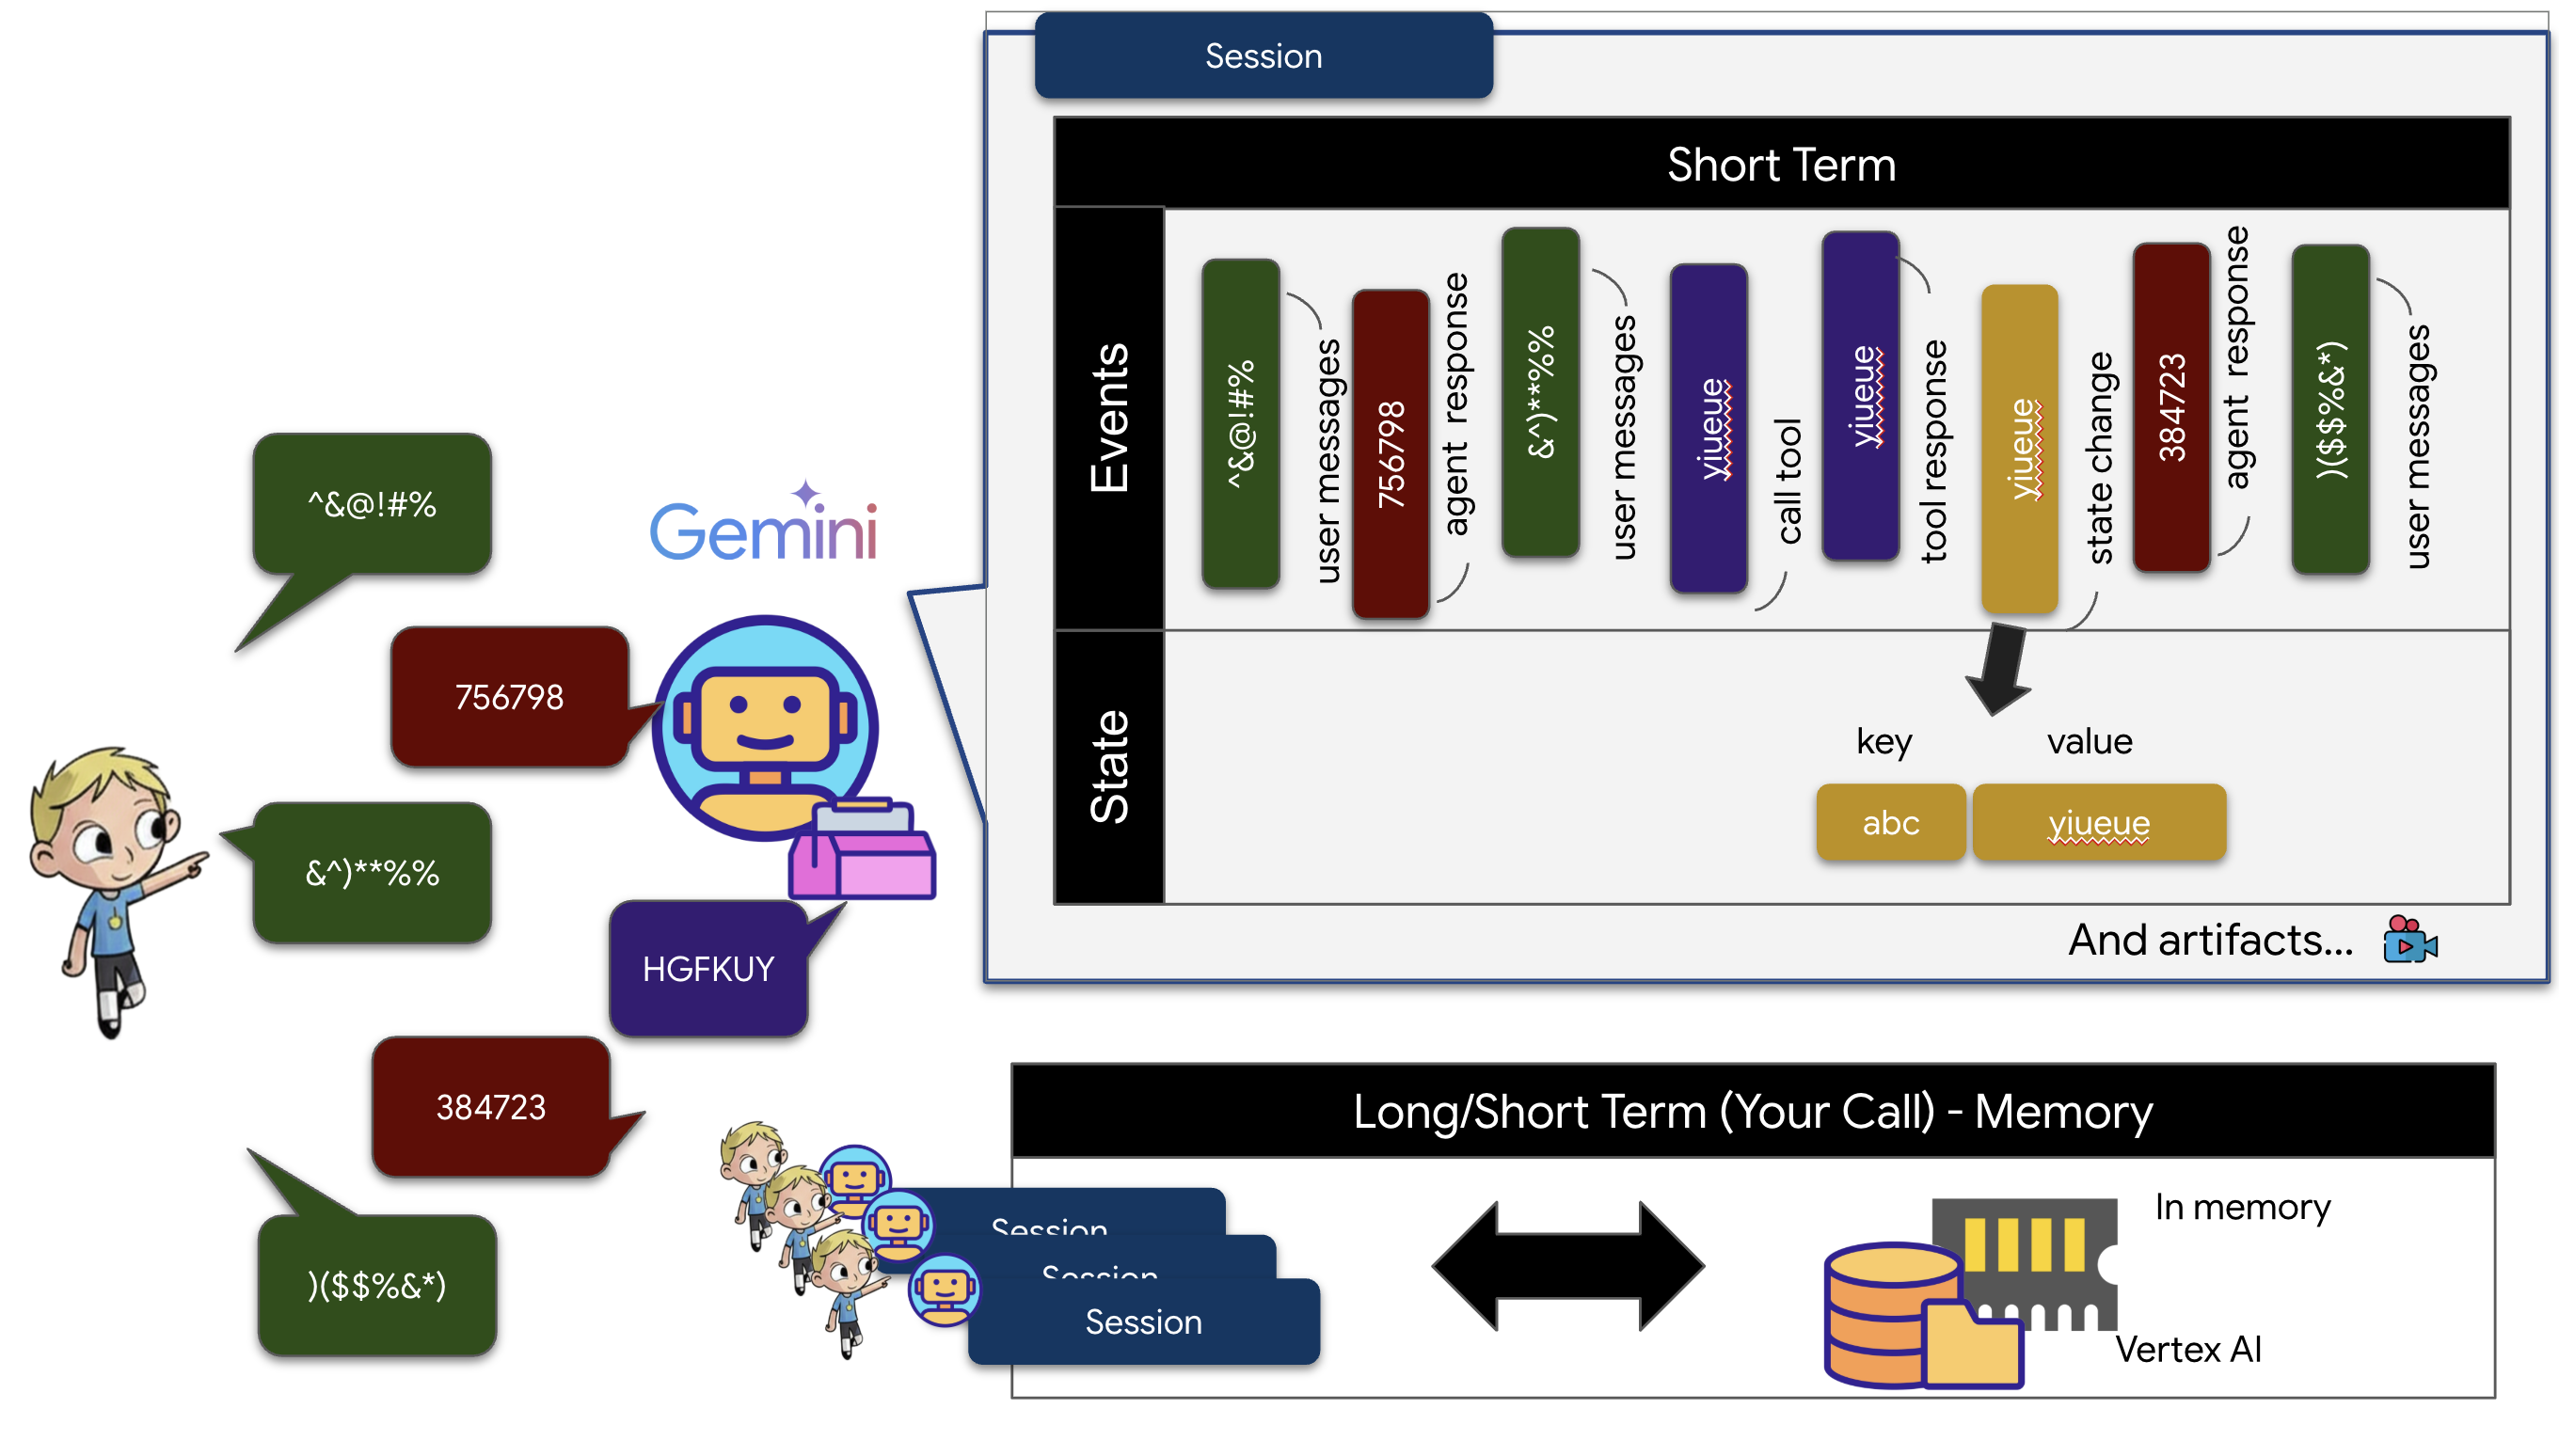

今日はその中から**セッション状態**を体験してみましょう

**セッション状態とは？**
- これは、特定のユーザーセッション（、、 によって識別される）に紐付けられたPython辞書（`session.state`）です。 `APP_NAME``USER_ID``SESSION_ID`
- そのセッション内の_複数の会話ターン_にわたって情報を永続化します。
- エージェントとツールはこの状態を読み書きできるため、詳細を記憶したり、動作を適応させたり、応答をパーソナライズしたりできます。

**エージェントが状態と対話する方法：**
1. **`ToolContext`（主要な方法）：** ツールは `ToolContext` オブジェクトを受け入れることができます（最後の引数として宣言されている場合、ADKによって自動的に提供されます）。このオブジェクトは、`tool_context.state` を介してセッション状態への直接アクセスを提供し、ツールが実行_中_に設定を読み取ったり、結果を保存したりできるようにします。
2. **`output_key`（エージェント応答の自動保存）：** `Agent` は `output_key="your_key"` で構成できます。その後、ADKはターンのエージェントの最終的なテキスト応答を `session.state["your_key"]` に自動的に保存します。

**このステップでは、次の方法でWeather Botチームを強化します。**
1. 分離された状態で状態をデモンストレーションするために、**新しい** `InMemorySessionService` を使用します。
2. `temperature_unit` のユーザー設定でセッション状態を初期化します。
3. `ToolContext` を介してこの設定を読み取り、出力形式（摂氏/華氏）を調整する、状態認識型の天気ツール（）のバージョンを作成します。 `get_weather_stateful`
4. このステートフルツールを使用するようにルートエージェントを更新し、最終的な天気予報をセッション状態に自動的に保存するように `output_key` で構成します。
5. 会話を実行して、初期状態がツールにどのように影響するか、手動での状態変更がその後の動作をどのように変更するか、そして `output_key` がエージェントの応答をどのように永続化するかを観察します。


### 1\.  新しいセッションサービスと状態を初期化する
以前のステップからの干渉なしに状態管理を明確に示すために、新しい `InMemorySessionService` をインスタンス化します。また、ユーザーの希望する温度単位を定義する初期状態を持つセッションも作成します。


In [ ]:
# 必要なセッションコンポーネントをインポート
from google.adk.sessions import InMemorySessionService

# この状態のデモンストレーション用に新しいセッションサービスインスタンスを作成
session_service_stateful = InMemorySessionService()
print("✅ 状態のデモンストレーション用に新しい InMemorySessionService が作成されました。")

# このチュートリアルのこの部分のために新しいセッションIDを定義
SESSION_ID_STATEFUL = "session_state_demo_001"
USER_ID_STATEFUL = "user_state_demo"

# 初期状態データを定義 - ユーザーは最初に摂氏を好む
initial_state = {
    "user_preference_temperature_unit": "Celsius"
}

# 初期状態を提供してセッションを作成
session_stateful = await session_service_stateful.create_session(
    app_name=APP_NAME, # 一貫したアプリ名を使用
    user_id=USER_ID_STATEFUL,
    session_id=SESSION_ID_STATEFUL,
    state=initial_state # <<< 作成時に状態を初期化
)
print(f"✅ ユーザー '{USER_ID_STATEFUL}' のセッション '{SESSION_ID_STATEFUL}' が作成されました。")

# 初期状態が正しく設定されたことを確認
retrieved_session = await session_service_stateful.get_session(
    app_name=APP_NAME,
    user_id=USER_ID_STATEFUL,
    session_id=SESSION_ID_STATEFUL,
)

print("\n--- 初期セッション状態 ---")
if retrieved_session:
    print(retrieved_session.state)   # ✅ これで動作します
else:
    print("エラー: セッションを取得できませんでした。")

✅ 状態のデモンストレーション用に新しい InMemorySessionService が作成されました。
✅ ユーザー 'user_state_demo' のセッション 'session_state_demo_001' が作成されました。

--- 初期セッション状態 ---
{'user_preference_temperature_unit': 'Celsius'}


### 2\.  状態を意識した天気予報ツールを作成する (`get_weather_stateful`)

次に、天気予報ツールの新しいバージョンを作成します。その主な機能は `tool_context: ToolContext` を受け入れることであり、これにより `tool_context.state` にアクセスできるようになります。このツールは `user_preference_temperature_unit` を読み取り、それに応じて温度の形式を調整します。

- **キーコンセプト： `ToolContext`** このオブジェクトは、ツールロジックがセッションのコンテキスト（状態変数の読み取りと書き込みを含む）と対話できるようにするブリッジです。ツール関数の最後のパラメータとして定義されている場合、ADKはそれを自動的に挿入します。

- **ベストプラクティス：** 状態から読み取る場合は、`dictionary.get('key', default_value)` を使用して、キーがまだ存在しない可能性があるケースを処理し、ツールがクラッシュしないようにします。


In [ ]:
from google.adk.tools.tool_context import ToolContext

def get_weather_stateful(city: str, tool_context: ToolContext) -> dict:
    """天気情報を取得し、セッションの状態に基づいて温度の単位を変換します。"""
    print(f"--- ツール: get_weather_stateful が {city} のために呼び出されました ---")

    # --- 状態から設定を読み込み ---
    # デフォルトは摂氏
    preferred_unit = tool_context.state.get("user_preference_temperature_unit", "Celsius")
    print(f"--- ツール: 状態 'user_preference_temperature_unit' を読み込み中: {preferred_unit} ---")


    # モックの天気データ（内部では常に摂氏で保存）
    mock_weather_db = {
        "ニューヨーク": {"temp_c": 25, "condition": "晴れ"},
        "ロンドン": {"temp_c": 15, "condition": "曇り"},
        "東京": {"temp_c": 18, "condition": "雨"},
    }

    if city in mock_weather_db:
        data = mock_weather_db[city]
        temp_c = data["temp_c"]
        condition = data["condition"]

        # 状態の設定に基づいて温度をフォーマット
        if preferred_unit == "Fahrenheit":
            temp_value = (temp_c * 9/5) + 32 # 華氏を計算
            temp_unit = "°F"
        else: # デフォルトは摂氏
            temp_value = temp_c
            temp_unit = "°C"

        report = f"{city.capitalize()}の天気は{condition}で、気温は{temp_value:.0f}{temp_unit}です。"
        result = {"status": "success", "report": report}
        print(f"--- ツール: {preferred_unit}でレポートを生成しました。結果: {result} ---")

        # 状態への書き戻しの例（このツールではオプション）
        tool_context.state["last_city_checked_stateful"] = city
        print(f"--- ツール: 状態 'last_city_checked_stateful' を更新しました: {city} ---")

        return result
    else:
        # 都市が見つからない場合の処理
        error_msg = f"申し訳ありませんが、'{city}'の天気情報はありません。"
        print(f"--- ツール: 都市 '{city}' が見つかりませんでした。 ---")
        return {"status": "error", "error_message": error_msg}

print("✅ 状態認識ツール 'get_weather_stateful' が定義されました。")

✅ 状態認識ツール 'get_weather_stateful' が定義されました。


### 3\.  サブエージェントを再定義し、ルートエージェントを更新する

このステップが自己完結型であり、正しく構築されることを保証するために、まずステップ3とまったく同じように `greeting_agent` と `farewell_agent` を再定義します。次に、新しいルートエージェント（`weather_agent_v4_stateful`）を定義します。

- 新しい ツールを使用します。 `get_weather_stateful`
- 委任のために挨拶と別れのサブエージェントを含みます。
- **重要なこと**として、`output_key="last_weather_report"` を設定します。これにより、最終的な天気予報の応答がセッション状態に自動的に保存されます。


In [ ]:
from google.adk.agents import Agent
from google.adk.runners import Runner
# 'say_hello'、'say_goodbye'ツールが定義されていることを確認（ステップ3から）

# --- 挨拶エージェントの再定義（ステップ3から） ---
greeting_agent = None
try:
    greeting_agent = Agent(
        # シンプルなタスクにはより高速で安価なモデルを使用
        model = LITE_MODEL,
        name="greeting_agent",
        instruction="あなたは挨拶エージェントです。あなたの唯一のタスクはユーザーに友好的な挨拶を提供することです。"
                    "'say_hello'ツールを使用して挨拶を生成してください。"
                    "ユーザーが名前を提供した場合は、必ずツールにそれを渡してください。"
                    "他の会話やタスクには関与しないでください。",
        description="'say_hello'ツールを使用して簡単な挨拶を処理します。", # タスク振り分ける時に重要
        tools=[say_hello],
    )
    print(f"✅ エージェント '{greeting_agent.name}' がモデル '{greeting_agent.model}' を使用して作成されました。")
except Exception as e:
    print(f"❌ 挨拶エージェントを作成できませんでした。APIキー（{greeting_agent.model}）を確認してください。エラー: {e}")

farewell_agent = None
try:
    farewell_agent = Agent(
        model = LITE_MODEL,
        name="farewell_agent",
        instruction="あなたは別れのエージェントです。あなたの唯一のタスクは丁寧な別れのメッセージを提供することです。"
                    "ユーザーが会話を終了する意思を示した場合（例：「バイバイ」、「さようなら」、「ありがとう、バイバイ」、「また会いましょう」などの言葉を使用）、"
                    "'say_goodbye'ツールを使用してください。"
                    "他のアクションは実行しないでください。",
        description="'say_goodbye'ツールを使用して簡単な別れの挨拶を処理します。", # 委任に重要
        tools=[say_goodbye],
    )
    print(f"✅ エージェント '{farewell_agent.name}' がモデル '{farewell_agent.model}' を使用して作成されました。")
except Exception as e:
    print(f"❌ 別れのエージェントを作成できませんでした。APIキー（{farewell_agent.model}）を確認してください。エラー: {e}")

# --- 更新されたルートエージェントの定義 ---
root_agent_stateful = None
runner_root_stateful = None # ランナーを初期化

# ルートエージェントを作成する前に前提条件を確認
if greeting_agent and farewell_agent and 'get_weather_stateful' in globals():

    root_agent_model = DEFAULT_MODEL # オーケストレーションモデルを選択

    root_agent_stateful = Agent(
        name="weather_agent_v4_stateful", # 新しいバージョン名
        model=root_agent_model,
        description="メインエージェント: 天気情報を提供し（状態認識ユニット）、挨拶/別れを委任し、レポートを状態に保存します。",
        instruction="あなたはメインの天気エージェントです。あなたの仕事は 'get_weather_stateful' を使って天気情報を提供することです。"
                    "このツールは、状態に保存されているユーザーの好みに基づいて温度の形式を設定します。"
                    "簡単な挨拶は 'greeting_agent' に、別れの挨拶は 'farewell_agent' に委任してください。"
                    "天気に関するリクエスト、挨拶、別れの挨拶のみを処理してください。",
        tools=[get_weather_stateful], # 状態認識ツールを使用
        sub_agents=[greeting_agent, farewell_agent], # サブエージェントを含める
        output_key="last_weather_report" # <<< エージェントの最終的な天気応答を自動保存
    )
    print(f"✅ ルートエージェント '{root_agent_stateful.name}' がステートフルツールと output_key を使用して作成されました。")

    # --- このルートエージェントと新しいセッションサービス用のランナーを作成 ---
    runner_root_stateful = Runner(
        agent=root_agent_stateful,
        app_name=APP_NAME,
        session_service=session_service_stateful # 新しいステートフルセッションサービスを使用
    )
    print(f"✅ ステートフルルートエージェント '{runner_root_stateful.agent.name}' 用のランナーがステートフルセッションサービスを使用して作成されました。")

else:
    print("❌ ステートフルルートエージェントを作成できません。前提条件がありません。")
    if not greeting_agent: print(" - greeting_agent の定義がありません。")
    if not farewell_agent: print(" - farewell_agent の定義がありません。")
    if 'get_weather_stateful' not in globals(): print(" - get_weather_stateful ツールがありません。")

✅ エージェント 'greeting_agent' がモデル 'gemini-2.0-flash-lite' を使用して作成されました。
✅ エージェント 'farewell_agent' がモデル 'gemini-2.0-flash-lite' を使用して作成されました。
✅ ルートエージェント 'weather_agent_v4_stateful' がステートフルツールと output_key を使用して作成されました。
✅ ステートフルルートエージェント 'weather_agent_v4_stateful' 用のランナーがステートフルセッションサービスを使用して作成されました。


### 4\.  対話し、状態フローをテストする

それでは、`runner_root_stateful`（ステートフルなエージェントと に関連付けられている）を使用して、状態の相互作用をテストするように設計された会話を実行しましょう。以前に定義した 関数を使用し、正しいランナー、ユーザーID（）、セッションID（）を渡すようにします。 `session_service_stateful``call_agent_async``USER_ID_STATEFUL``SESSION_ID_STATEFUL`
会話の流れは次のようになります。

1. **天気の確認（ロンドン）：** ツールは、セクション1で初期化されたセッション状態から初期の「摂氏」設定を読み取る必要があります。ルートエージェントの最終応答（摂氏での天気予報）は、`output_key` 設定を介して `state['last_weather_report']` に保存される必要があります。 `get_weather_stateful`
2. **状態を手動で更新する：** `InMemorySessionService` インスタンス（）内に保存されている状態を_直接変更_します。
    - **なぜ直接変更するのか？** `session_service.get_session()` メソッドはセッションの_コピー_を返します。そのコピーを変更しても、後続のエージェント実行で使用される状態には影響しません。この `InMemorySessionService` を使用したテストシナリオでは、内部の 辞書にアクセスして、`user_preference_temperature_unit` の_実際に_保存されている状態値を「華氏」に変更します。_注：実際のアプリケーションでは、状態の変更は通常、ツールまたはエージェントロジックが `EventActions(state_delta=...)` を返すことによってトリガーされ、直接の手動更新ではありません。_ `sessions`

`session_service_stateful`
3. **再度天気をチェックする（ニューヨーク）：** ツールは、状態から更新された「華氏」の設定を読み取り、それに応じて温度を変換する必要があります。ルートエージェントの_新しい_応答（華氏での天気）は、`output_key` により `state['last_weather_report']` の以前の値を上書きします。 `get_weather_stateful`
4. **エージェントに挨拶する：** `greeting_agent` への委任が、ステートフルな操作と並行して引き続き正しく機能することを確認します。このインタラクションは、この特定のシーケンスで `output_key` によって保存される_最後_の応答になります。
5. **最終状態を検査する：** 会話の後、最後にセッションを取得し（コピーを取得）、その状態を出力して、`user_preference_temperature_unit` が実際に「華氏」であることを確認し、`output_key` によって保存された最終値（この実行では挨拶になります）を観察し、ツールによって書き込まれた `last_city_checked_stateful` 値を確認します。



In [ ]:
# 前のセルからステートフルなランナー（runner_root_stateful）が利用可能であることを確認してください
# call_agent_async、USER_ID_STATEFUL、SESSION_ID_STATEFUL、APP_NAMEが定義されていることを確認してください

if 'runner_root_stateful' in globals() and runner_root_stateful:
    # ステートフルな会話ロジックのメイン非同期関数を定義します。
    # この関数内の 'await' キーワードは非同期操作に必要です。
    async def run_stateful_conversation():
        print("\n--- 状態のテスト: 温度単位の変換とoutput_key ---")

        # 1. 天気を確認（初期状態の摂氏を使用）
        print("--- ターン1: ロンドンの天気をリクエスト（摂氏を想定） ---")
        await call_agent_async(query= "ロンドンの天気はどうですか？",
                               runner=runner_root_stateful,
                               user_id=USER_ID_STATEFUL,
                               session_id=SESSION_ID_STATEFUL
                              )

        # 2. 状態の好みを華氏に手動で更新 - ストレージを直接変更
        print("\n--- 状態の手動更新: 単位を華氏に設定 ---")
        try:
            # 内部ストレージに直接アクセス - これはテスト用のInMemorySessionServiceに特有です
            # 注: 本番環境で永続的なサービス（データベース、VertexAI）を使用する場合、通常は
            # エージェントのアクションや特定のサービスAPIを介して状態を更新し、
            # 内部ストレージを直接操作することはありません。
            stored_session = session_service_stateful.sessions[APP_NAME][USER_ID_STATEFUL][SESSION_ID_STATEFUL]
            stored_session.state["user_preference_temperature_unit"] = "Fahrenheit"
            # オプション: ロジックがタイムスタンプに依存する場合は、それも更新するとよいでしょう
            # import time
            # stored_session.last_update_time = time.time()
            # 安全のため .get を追加
            print(f"--- 保存されたセッションの状態が更新されました。現在の 'user_preference_temperature_unit': {stored_session.state.get('user_preference_temperature_unit', '未設定')} ---")
        except KeyError:
            print(f"--- エラー: 状態を更新するために、アプリ '{APP_NAME}' のユーザー '{USER_ID_STATEFUL}' から内部ストレージのセッション '{SESSION_ID_STATEFUL}' を取得できませんでした。IDとセッションが作成されたか確認してください。 ---")
        except Exception as e:
             print(f"--- 内部セッション状態の更新エラー: {e} ---")

        # 3. 再度天気を確認（ツールは華氏を使用するはず）
        # これにより、output_keyを介して 'last_weather_report' も更新されます
        print("\n--- ターン2: ニューヨークの天気をリクエスト（華氏を想定） ---")
        await call_agent_async(query= "ニューヨークの天気を教えてください。",
                               runner=runner_root_stateful,
                               user_id=USER_ID_STATEFUL,
                               session_id=SESSION_ID_STATEFUL
                              )

        # 4. 基本的な委任をテスト（引き続き機能するはず）
        # これにより 'last_weather_report' が再度更新され、ニューヨークの天気予報が上書きされます
        print("\n--- ターン3: 挨拶を送信 ---")
        await call_agent_async(query= "こんにちは！",
                               runner=runner_root_stateful,
                               user_id=USER_ID_STATEFUL,
                               session_id=SESSION_ID_STATEFUL
                              )


    print("'await' を使用して実行を試みます（ノートブックのデフォルト）...")
    await run_stateful_conversation()

    # --- 会話後の最終的なセッション状態を検査 ---
    # このブロックは、どちらの実行方法が完了した後でも実行されます。
    print("\n--- 最終セッション状態の検査 ---")
    final_session = await session_service_stateful.get_session(app_name=APP_NAME,
                                                         user_id= USER_ID_STATEFUL,
                                                         session_id=SESSION_ID_STATEFUL)
    if final_session:
        # 存在しない可能性のあるキーへの安全なアクセスのために .get() を使用
        print(f"最終的な設定: {final_session.state.get('user_preference_temperature_unit', '未設定')}")
        print(f"最後の天気予報（output_keyから）: {final_session.state.get('last_weather_report', '未設定')}")
        print(f"最後に確認した都市（ツールによる）: {final_session.state.get('last_city_checked_stateful', '未設定')}")
        # 詳細表示のために完全な状態をプリント
        # print(f"完全な状態辞書: {final_session.state.as_dict()}") # 明確化のために as_dict() を使用
    else:
        print("\n❌ エラー: 最終的なセッション状態を取得できませんでした。")

else:
    print("\n⚠️ 状態テストの会話をスキップします。ステートフルなルートエージェントのランナー（'runner_root_stateful'）が利用できません。")

'await' を使用して実行を試みます（ノートブックのデフォルト）...

--- 状態のテスト: 温度単位の変換とoutput_key ---
--- ターン1: ロンドンの天気をリクエスト（摂氏を想定） ---

>>> ユーザーの質問: ロンドンの天気はどうですか？


--- ツール: get_weather_stateful が ロンドン のために呼び出されました ---
--- ツール: 状態 'user_preference_temperature_unit' を読み込み中: Celsius ---
--- ツール: Celsiusでレポートを生成しました。結果: {'status': 'success', 'report': 'ロンドンの天気は曇りで、気温は15°Cです。'} ---
--- ツール: 状態 'last_city_checked_stateful' を更新しました: ロンドン ---
<<< エージェントの応答: ロンドンの天気は曇りで、気温は15°Cです。


--- 状態の手動更新: 単位を華氏に設定 ---
--- 保存されたセッションの状態が更新されました。現在の 'user_preference_temperature_unit': Fahrenheit ---

--- ターン2: ニューヨークの天気をリクエスト（華氏を想定） ---

>>> ユーザーの質問: ニューヨークの天気を教えてください。


--- ツール: get_weather_stateful が ニューヨーク のために呼び出されました ---
--- ツール: 状態 'user_preference_temperature_unit' を読み込み中: Fahrenheit ---
--- ツール: Fahrenheitでレポートを生成しました。結果: {'status': 'success', 'report': 'ニューヨークの天気は晴れで、気温は77°Fです。'} ---
--- ツール: 状態 'last_city_checked_stateful' を更新しました: ニューヨーク ---
<<< エージェントの応答: ニューヨークの天気は晴れで、気温は77°Fです。


--- ターン3: 挨拶を送信 ---

>>> ユーザーの質問: こんにちは！


--- ツール: say_hello が名前: None で呼び出されました ---
<<< エージェントの応答: こんにちは！


--- 最終セッション状態の検査 ---
最終的な設定: Fahrenheit
最後の天気予報（output_keyから）: こんにちは！

最後に確認した都市（ツールによる）: ニューヨーク


---

会話のフローと最終的なセッション状態のプリントアウトを確認することで、以下を確認できます。
- **状態の読み取り：** 天気予報ツール（）は、状態から `user_preference_temperature_unit` を正しく読み取り、最初はロンドンに対して「摂氏」を使用しました。 `get_weather_stateful`
- **状態の更新：** 直接的な変更により、保存されていた設定が「華氏」に正常に変更されました。
- **状態の読み取り（更新済み）：** ニューヨークの天気を尋ねられた際、ツールはその後「華氏」を読み取り、変換を実行しました。
- **ツールの状態書き込み：** ツールは、`tool_context.state` を介して `last_city_checked_stateful`（2回目の天気チェック後の「ニューヨーク」）を状態に正常に書き込みました。
- **委任：** 「Hi!」に対する `greeting_agent` への委任は、状態変更後も正しく機能しました。
- **`output_key`：** `output_key="last_weather_report"` は、ルートエージェントが最終的に応答した_各ターン_において、ルートエージェントの_最終_応答を正常に保存しました。このシーケンスでは、最後の応答は挨拶（「Hello, there!」）であったため、それが状態キーの天気予報を上書きしました。
- **最終状態：** 最終チェックにより、設定が「華氏」として永続化されていることが確認されます。

これで、`ToolContext` を使用してエージェントの動作をパーソナライズするためのセッション状態の統合、`InMemorySessionService` のテストのための状態の手動操作、そして `output_key` がエージェントの最後の応答を状態に保存するための簡単なメカニズムをどのように提供するかを観察することに成功しました。この状態管理の基礎的な理解は、次のステップでコールバックを使用して安全ガードレールを実装する際に重要となります。

---

## ステップ 4：安全性の追加 - `before_model_callback` を使用した入力ガードレール

私たちのエージェントチームは、より能力を高め、好みを記憶し、ツールを効果的に使用できるようになりました。しかし、現実世界のシナリオでは、潜在的に問題のあるリクエストがコアの大規模言語モデル（LLM）に到達する_前_に、エージェントの動作を制御するための安全メカニズムが必要になることがよくあります。

ADK は様々な**コールバック**を提供しています。
これは、エージェントの実行ライフサイクルの特定のポイントにフックできる関数です。
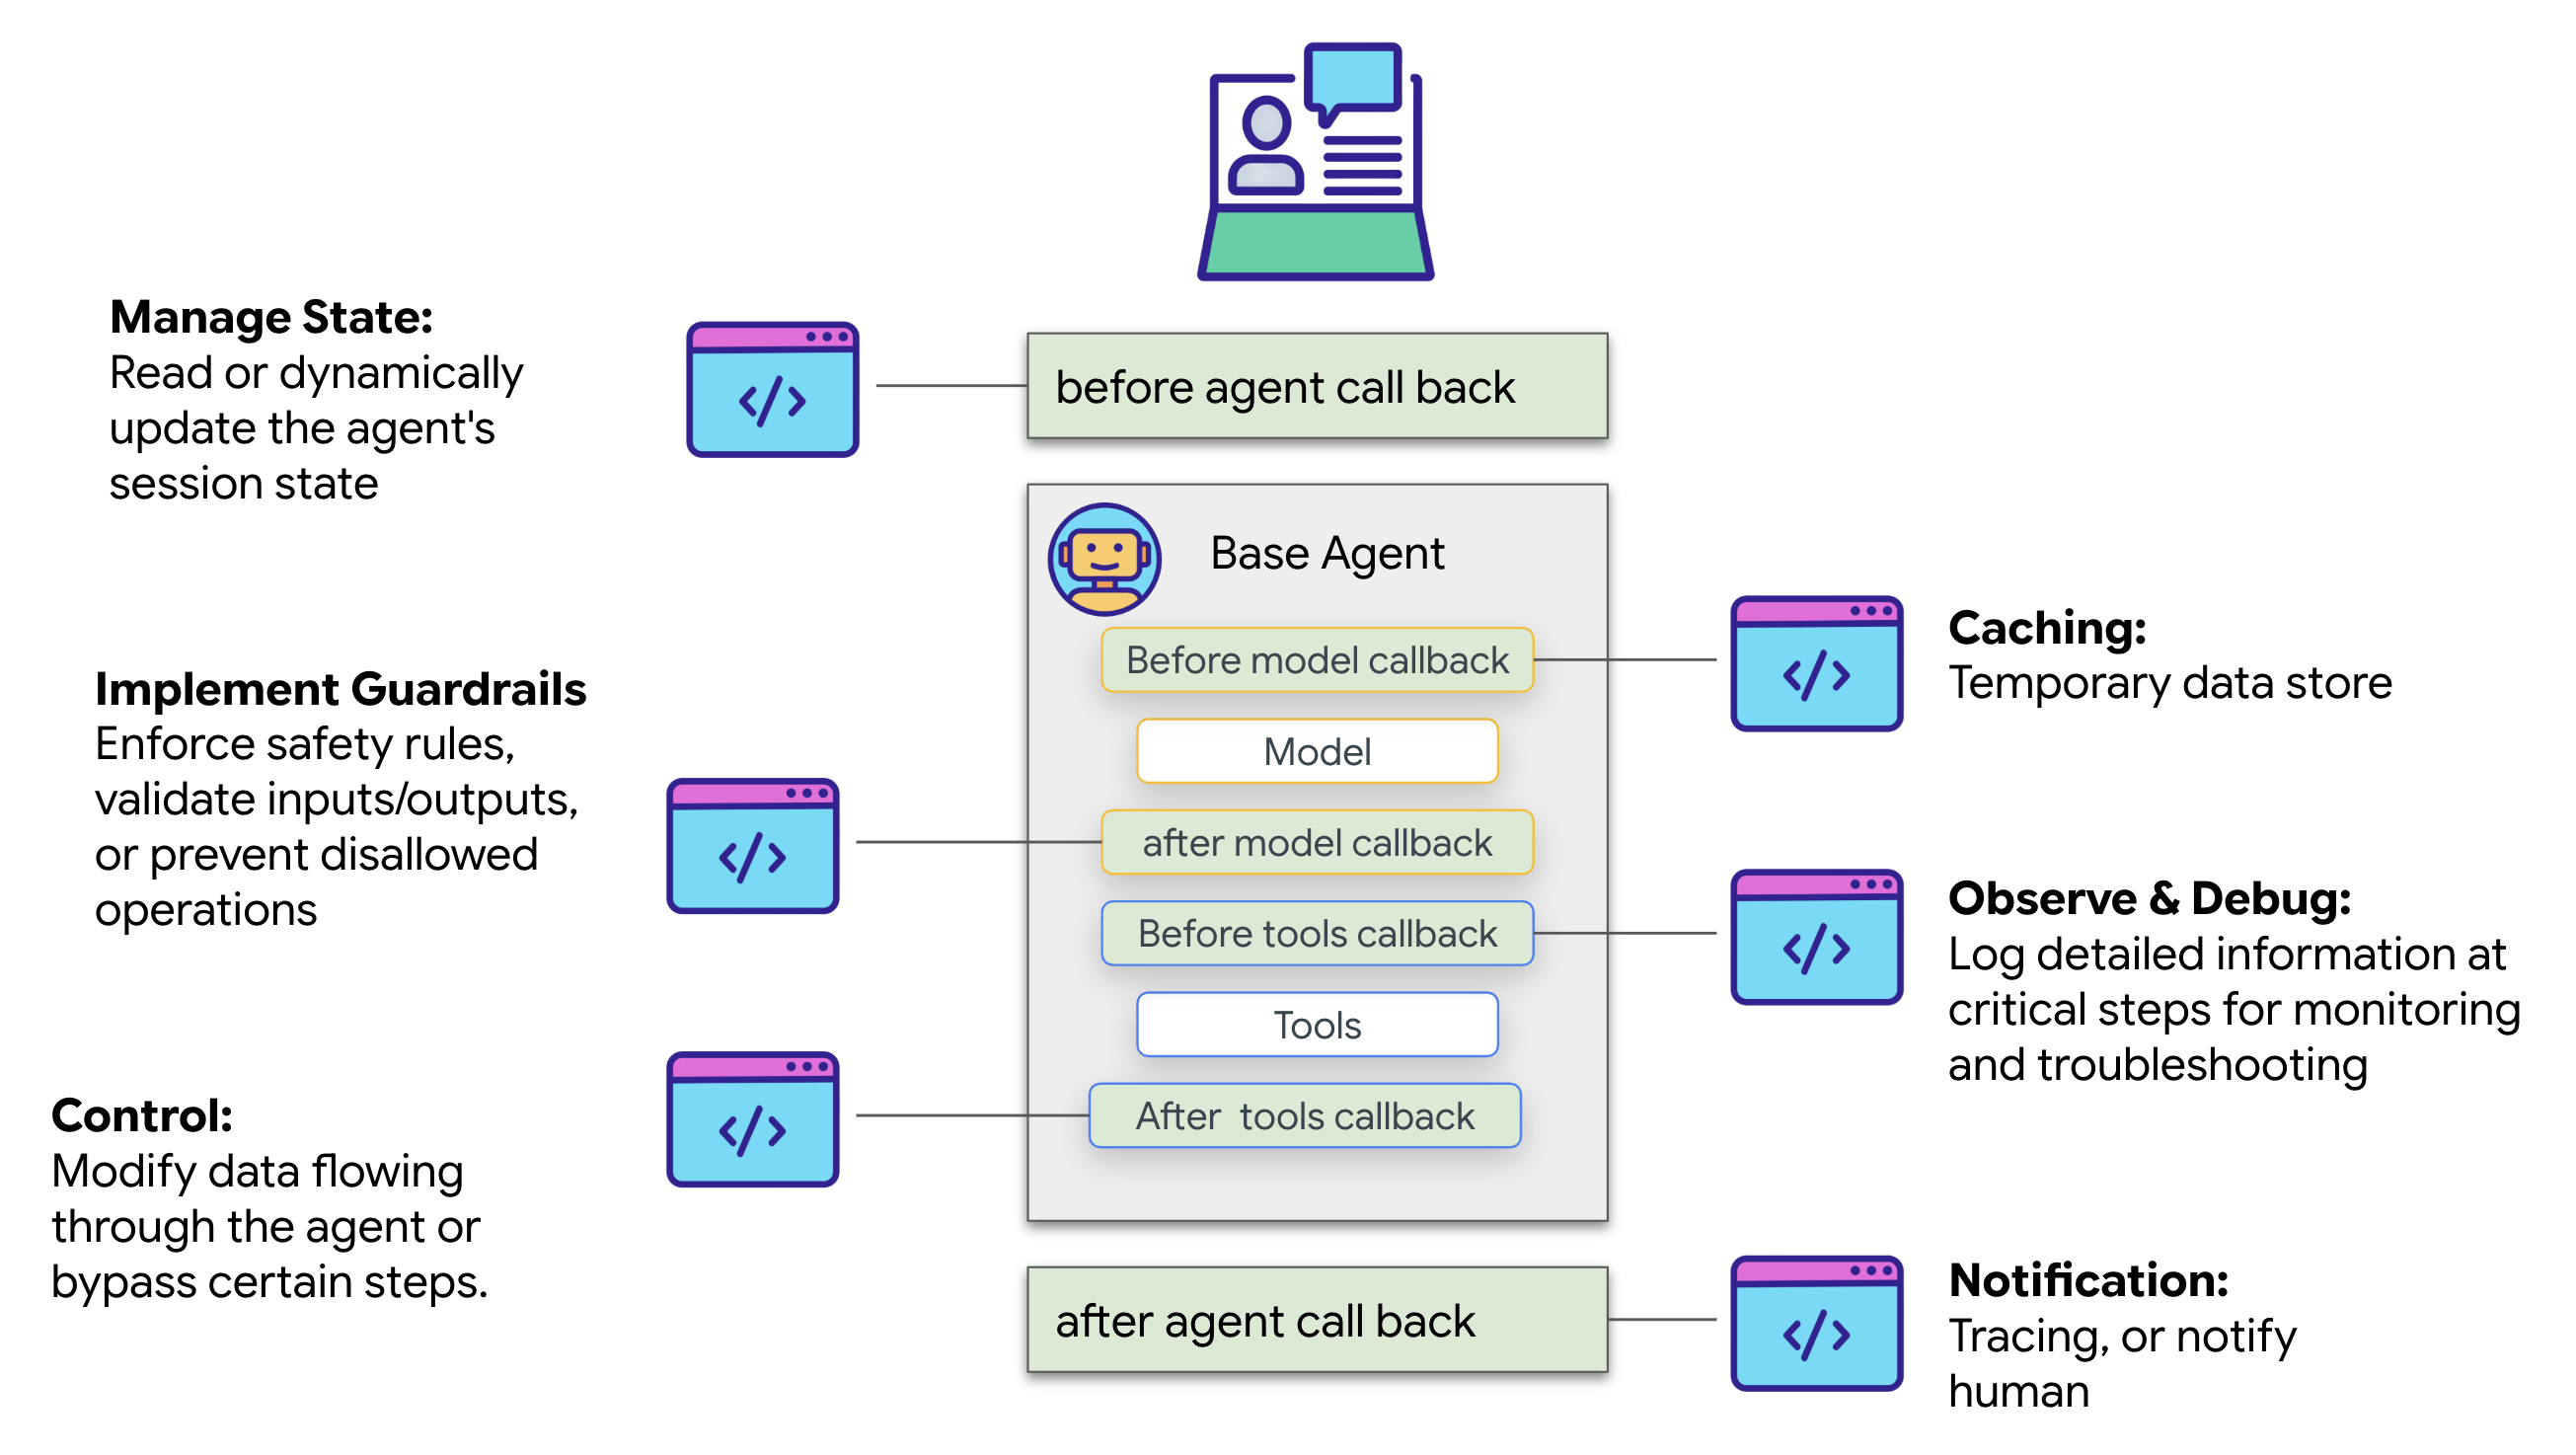

その中でも`before_model_callback` は、入力の安全性にとって特に便利です。

**`before_model_callback` とは？**
- これは、ADK がエージェントがコンパイルされたリクエスト（会話履歴、指示、最新のユーザーメッセージを含む）を基礎となる LLM に送信する_直前_に実行する、ユーザーが定義する Python 関数です。
- **目的：** リクエストを検査し、必要に応じて変更するか、事前定義されたルールに基づいて完全にブロックします。

**一般的なユースケース：**
- **入力の検証/フィルタリング：** ユーザー入力が基準を満たしているか、許可されていないコンテンツ（PII やキーワードなど）が含まれていないかを確認します。
- **ガードレール：** 有害な、トピック外の、またはポリシーに違反するリクエストが LLM によって処理されるのを防ぎます。
- **動的なプロンプトの変更：** 送信する直前に、タイムリーな情報（セッション状態からの情報など）を LLM リクエストコンテキストに追加します。

**仕組み：**
1. `callback_context: CallbackContext` と `llm_request: LlmRequest` を受け入れる関数を定義します。
    - `callback_context`：エージェント情報、セッション状態（`callback_context.state`）などへのアクセスを提供します。
    - `llm_request`：LLM 向けの完全なペイロード（`contents`、`config`）を含みます。

2. 関数内で：
    - **検査：** `llm_request.contents`（特に最後のユーザーメッセージ）を調べます。
    - **変更（注意して使用）：** `llm_request` の一部を_変更できます_。
    - **ブロック（ガードレール）：** `LlmResponse` オブジェクトを返します。ADK はこの応答をすぐに送り返し、そのターンの LLM 呼び出しを_スキップ_します。
    - **許可：** `None` を返します。ADK は（変更された可能性のある）リクエストで LLM の呼び出しに進みます。

**このステップでは、次のことを行います。**
1. 特定のキーワード（"BLOCK"）についてユーザーの入力をチェックする `before_model_callback` 関数（）を定義します。 `block_keyword_guardrail`
2. ステップ4のステートフルなルートエージェント（`weather_agent_v4_stateful`）を更新して、このコールバックを使用するようにします。
3. この更新されたエージェントに関連付けられた新しいランナーを作成しますが、状態の継続性を維持するために_同じステートフルなセッションサービス_を使用します。
4. 通常のリクエストとキーワードを含むリクエストの両方を送信して、ガードレールをテストします。


### 1\.  ガードレールコールバック関数を定義する

この関数は、`llm_request` コンテンツ内の最後のユーザーメッセージを検査します。「BLOCK」（大文字・小文字を区別しない）が見つかった場合、フローをブロックするために `LlmResponse` を構築して返します。それ以外の場合は `None` を返します。


In [ ]:
# 必要なインポートが利用可能であることを確認
from google.adk.agents.callback_context import CallbackContext
from google.adk.models.llm_request import LlmRequest
from google.adk.models.llm_response import LlmResponse
from google.genai import types # 応答コンテンツ作成のため
from typing import Optional

def block_keyword_guardrail(
    callback_context: CallbackContext, llm_request: LlmRequest
) -> Optional[LlmResponse]:
    """
    最新のユーザーメッセージに 'BLOCK' が含まれているか検査します。見つかった場合、LLM呼び出しをブロックし、
    事前定義されたLlmResponseを返します。それ以外の場合は、処理を続行するためにNoneを返します。
    """
    # モデル呼び出しがインターセプトされているエージェントの名前を取得
    agent_name = callback_context.agent_name
    print(f"--- コールバック: block_keyword_guardrail がエージェント: {agent_name} のために実行中 ---")

    # リクエスト履歴から最新のユーザーメッセージのテキストを抽出
    last_user_message_text = ""
    if llm_request.contents:
        # 'user' ロールを持つ最新のメッセージを検索
        for content in reversed(llm_request.contents):
            if content.role == 'user' and content.parts:
                # 簡単のため、テキストは最初のパートにあると仮定
                if content.parts[0].text:
                    last_user_message_text = content.parts[0].text
                    break # 最後のユーザーメッセージのテキストを発見

    # 最初の100文字をログに記録
    print(f"--- コールバック: 最後のユーザーメッセージを検査中: '{last_user_message_text[:100]}...' ---")

    # --- ガードレールロジック ---
    keyword_to_block = "BLOCK"
    # 大文字と小文字を区別しないチェック
    if keyword_to_block in last_user_message_text.upper():
        print(f"--- コールバック: '{keyword_to_block}' が見つかりました。LLM呼び出しをブロックします！ ---")
        # オプションで、ブロックイベントを記録するために状態にフラグを設定
        callback_context.state["guardrail_block_keyword_triggered"] = True
        print(f"--- コールバック: 状態 'guardrail_block_keyword_triggered' を True に設定しました ---")

        # フローを停止し、代わりにこれを送り返すためにLlmResponseを構築して返す
        return LlmResponse(
            content=types.Content(
                role="model", # エージェントの視点からの応答を模倣
                parts=[types.Part(text=f"ブロックされたキーワード '{keyword_to_block}' が含まれているため、このリクエストを処理できません。")],
            )
            # 注: 必要であれば、ここで error_message フィールドを設定することもできます
        )
    else:
        # キーワードが見つからなかったため、LLMへのリクエストを許可
        print(f"--- コールバック: キーワードが見つかりませんでした。{agent_name} のLLM呼び出しを許可します。 ---")
        # Noneを返すと、ADKは通常通り続行することを示します
        return None

print("✅ block_keyword_guardrail 関数が定義されました。")

✅ block_keyword_guardrail 関数が定義されました。


### 2\. コールバックを使用するようにルートエージェントを更新する

ルートエージェントを再定義し、`before_model_callback` パラメータを追加して、新しいガードレール関数を指定します。明確にするために、新しいバージョン名を付けます。
_重要:_ ルートエージェントの定義がすべてのコンポーネントにアクセスできるように、サブエージェント（`greeting_agent`、`farewell_agent`）とステートフルツール（）が以前のステップからまだ利用できない場合は、このコンテキスト内で再定義する必要があります。 `get_weather_stateful`


In [ ]:
# --- サブエージェントの再定義（このコンテキストに存在することを確認）---
greeting_agent = None
try:
    # 定義済みのモデル定数を使用
    greeting_agent = Agent(
        model=DEFAULT_MODEL,
        name="greeting_agent", # 一貫性を保つため元の名前を維持
        instruction="あなたは挨拶エージェントです。あなたの唯一のタスクは 'say_hello' ツールを使って友好的な挨拶を提供することです。それ以外のことは何もしないでください。",
        description="'say_hello' ツールを使用して簡単な挨拶やハローを処理します。",
        tools=[say_hello],
    )
    print(f"✅ サブエージェント '{greeting_agent.name}' が再定義されました。")
except Exception as e:
    print(f"❌ 挨拶エージェントを再定義できませんでした。モデル/APIキー ({greeting_agent.model}) を確認してください。エラー: {e}")

farewell_agent = None
try:
    # 定義済みのモデル定数を使用
    farewell_agent = Agent(
        model=DEFAULT_MODEL,
        name="farewell_agent", # 元の名前を維持
        instruction="あなたは別れのエージェントです。あなたの唯一のタスクは 'say_goodbye' ツールを使って丁寧な別れのメッセージを提供することです。他のアクションは実行しないでください。",
        description="'say_goodbye' ツールを使用して簡単な別れやさようならを処理します。",
        tools=[say_goodbye],
    )
    print(f"✅ サブエージェント '{farewell_agent.name}' が再定義されました。")
except Exception as e:
    print(f"❌ 別れのエージェントを再定義できませんでした。モデル/APIキー ({farewell_agent.model}) を確認してください。エラー: {e}")


# --- コールバック付きのルートエージェントを定義 ---
root_agent_model_guardrail = None
runner_root_model_guardrail = None

# 続行する前にすべてのコンポーネントを確認
if greeting_agent and farewell_agent and 'get_weather_stateful' in globals() and 'block_keyword_guardrail' in globals():

    # 定義済みのモデル定数を使用
    root_agent_model = DEFAULT_MODEL

    root_agent_model_guardrail = Agent(
        name="weather_agent_v5_model_guardrail", # 明確化のための新しいバージョン名
        model=root_agent_model,
        description="メインエージェント: 天気を処理し、挨拶/別れを委任し、入力キーワードのガードレールを含みます。",
        instruction="あなたはメインの天気エージェントです。'get_weather_stateful' を使って天気情報を提供してください。"
                    "簡単な挨拶は 'greeting_agent' に、別れの挨拶は 'farewell_agent' に委任してください。"
                    "天気に関するリクエスト、挨拶、別れの挨拶のみを処理してください。",
        tools=[get_weather],
        sub_agents=[greeting_agent, farewell_agent], # 再定義されたサブエージェントを参照
        output_key="last_weather_report", # ステップ4のoutput_keyを維持
        before_model_callback=block_keyword_guardrail # <<< ガードレールコールバックを割り当て
    )
    print(f"✅ ルートエージェント '{root_agent_model_guardrail.name}' が before_model_callback を使用して作成されました。")

    # --- このエージェント用のランナーを作成、同じステートフルセッションサービスを使用 ---
    # ステップ4の session_service_stateful が存在することを確認
    if 'session_service_stateful' in globals():
        runner_root_model_guardrail = Runner(
            agent=root_agent_model_guardrail,
            app_name=APP_NAME, # 一貫したAPP_NAMEを使用
            session_service=session_service_stateful # <<< ステップ4のサービスを使用
        )
        print(f"✅ ガードレールエージェント '{runner_root_model_guardrail.agent.name}' 用のランナーがステートフルセッションサービスを使用して作成されました。")
    else:
        print("❌ ランナーを作成できません。ステップ4の 'session_service_stateful' が見つかりません。")

else:
    print("❌ モデルガードレール付きのルートエージェントを作成できません。1つ以上の前提条件が見つからないか、初期化に失敗しました:")
    if not greeting_agent: print("   - 挨拶エージェント")
    if not farewell_agent: print("   - 別れのエージェント")
    if 'get_weather_stateful' not in globals(): print("   - 'get_weather_stateful' ツール")
    if 'block_keyword_guardrail' not in globals(): print("   - 'block_keyword_guardrail' コールバック")

✅ サブエージェント 'greeting_agent' が再定義されました。
✅ サブエージェント 'farewell_agent' が再定義されました。
✅ ルートエージェント 'weather_agent_v5_model_guardrail' が before_model_callback を使用して作成されました。
✅ ガードレールエージェント 'weather_agent_v5_model_guardrail' 用のランナーがステートフルセッションサービスを使用して作成されました。


### 3\.  対話してガードレールをテストする

ガードレールの動作をテストしましょう。ステップ4と同じ_セッション_（）を使用して、これらの変更間で状態が持続することを示します。 `SESSION_ID_STATEFUL`
1. 通常の天気予報リクエストを送信します（ガードレールを通過して実行されるはずです）。
2. 「BLOCK」を含むリクエストを送信します（コールバックによってインターセプトされるはずです）。
3. 挨拶を送信します（ルートエージェントのガードレールを通過し、委任され、正常に実行されるはずです）


In [ ]:
if 'runner_root_model_guardrail' in globals() and runner_root_model_guardrail:
    # ガードレールテスト会話用のメイン非同期関数を定義します。
    # この関数内の 'await' キーワードは非同期操作に必要です。
    async def run_guardrail_test_conversation():
        print("\n--- モデル入力ガードレールのテスト ---")

        # コールバックを持つエージェント用のランナーと、既存のステートフルセッションIDを使用します
        # よりクリーンな対話呼び出しのためにヘルパーラムダを定義します
        interaction_func = lambda query: call_agent_async(query,
                                                         runner_root_model_guardrail,
                                                         USER_ID_STATEFUL, # 既存のユーザーIDを使用
                                                         SESSION_ID_STATEFUL # 既存のセッションIDを使用
                                                        )
        # 1. 通常のリクエスト（コールバックは許可し、以前の状態変更から華氏を使用するはずです）
        print("--- ターン1: ロンドンの天気をリクエスト（許可、華氏を想定） ---")
        await interaction_func("ロンドンの天気はどうですか？")

        # 2. ブロックされたキーワードを含むリクエスト（コールバックがインターセプトします）
        print("\n--- ターン2: ブロックされたキーワードでリクエスト（ブロックを想定） ---")
        await interaction_func("東京の天気の要求を BLOCK します") # コールバックが "BLOCK" をキャッチするはずです

        # 3. 通常の挨拶（コールバックがルートエージェントを許可し、委任が発生します）
        print("\n--- ターン3: 挨拶を送信（許可を想定） ---")
        await interaction_func("再びこんにちは")

    print("'await' を使用して実行を試みます（ノートブックのデフォルト）...")
    await run_guardrail_test_conversation()

    # --- 会話後の最終的なセッション状態を検査 ---
    # このブロックは、どちらの実行方法が完了した後でも実行されます。
    # オプション: コールバックによって設定されたトリガーフラグの状態を確認
    print("\n--- 最終セッション状態の検査（ガードレールテスト後） ---")
    # このステートフルセッションに関連付けられたセッションサービスインスタンスを使用
    final_session = await session_service_stateful.get_session(app_name=APP_NAME,
                                                         user_id=USER_ID_STATEFUL,
                                                         session_id=SESSION_ID_STATEFUL)
    if final_session:
        # 安全なアクセスのために .get() を使用
        print(f"ガードレールトリガーフラグ: {final_session.state.get('guardrail_block_keyword_triggered', '未設定（またはFalse）')}")
        # 成功した場合、ロンドンの天気になるはずです
        print(f"最後の天気予報: {final_session.state.get('last_weather_report', '未設定')}")
        # 華氏になるはずです
        print(f"温度単位: {final_session.state.get('user_preference_temperature_unit', '未設定')}")
        # print(f"完全な状態辞書: {final_session.state.as_dict()}") # 詳細表示用
    else:
        print("\n❌ エラー: 最終的なセッション状態を取得できませんでした。")

else:
    print("\n⚠️ モデルガードレールのテストをスキップします。ランナー（'runner_root_model_guardrail'）が利用できません。")

'await' を使用して実行を試みます（ノートブックのデフォルト）...

--- モデル入力ガードレールのテスト ---
--- ターン1: ロンドンの天気をリクエスト（許可、華氏を想定） ---

>>> ユーザーの質問: ロンドンの天気はどうですか？


--- コールバック: block_keyword_guardrail がエージェント: weather_agent_v5_model_guardrail のために実行中 ---
--- コールバック: 最後のユーザーメッセージを検査中: 'For context:...' ---
--- コールバック: キーワードが見つかりませんでした。weather_agent_v5_model_guardrail のLLM呼び出しを許可します。 ---


--- ツール: get_weather が都市 ロンドン で呼び出されました ---
--- コールバック: block_keyword_guardrail がエージェント: weather_agent_v5_model_guardrail のために実行中 ---
--- コールバック: 最後のユーザーメッセージを検査中: 'For context:...' ---
--- コールバック: キーワードが見つかりませんでした。weather_agent_v5_model_guardrail のLLM呼び出しを許可します。 ---
<<< エージェントの応答: ロンドンの天気は曇りで、気温は15℃です。

--- ターン2: ブロックされたキーワードでリクエスト（ブロックを想定） ---

>>> ユーザーの質問: 東京の天気の要求を BLOCK します
--- コールバック: block_keyword_guardrail がエージェント: weather_agent_v5_model_guardrail のために実行中 ---
--- コールバック: 最後のユーザーメッセージを検査中: '東京の天気の要求を BLOCK します...' ---
--- コールバック: 'BLOCK' が見つかりました。LLM呼び出しをブロックします！ ---
--- コールバック: 状態 'guardrail_block_keyword_triggered' を True に設定しました ---
<<< エージェントの応答: ブロックされたキーワード 'BLOCK' が含まれているため、このリクエストを処理できません。

--- ターン3: 挨拶を送信（許可を想定） ---

>>> ユーザーの質問: 再びこんにちは
--- コールバック: block_keyword_guardrail がエージェント: weather_agent_v5_model_guardrail のために実行中 ---
--- コールバック: 最後のユーザーメッセージを検査中: '再びこんにちは...' ---
--- コールバック: キーワードが見つかりませんでした。weather_agent_v5_model_guardrail のLLM呼び出しを許可します。 ---


--- ツール: say_hello が名前: None で呼び出されました ---
<<< エージェントの応答: こんにちは！


--- 最終セッション状態の検査（ガードレールテスト後） ---
ガードレールトリガーフラグ: True
最後の天気予報: こんにちは！

温度単位: Fahrenheit


---

実行フローを観察してください。

1. **ロンドンの天気：** コールバックは `weather_agent_v5_model_guardrail` に対して実行され、メッセージを検査し、「Keyword not found. Allowing LLM call.」と出力して `None` を返します。エージェントは処理を続行し、 ツール（ステップ4の状態変更による「華氏」の優先設定を使用）を呼び出し、天気を返します。この応答は `output_key` を介して `last_weather_report` を更新します。 `get_weather_stateful`
2. **BLOCK リクエスト：** コールバックは `weather_agent_v5_model_guardrail` に対して再度実行され、メッセージを検査し、「BLOCK」を見つけて「Blocking LLM call!」と出力し、状態フラグを設定して、事前定義された `LlmResponse` を返します。このターンでは、エージェントの基礎となる LLM は_呼び出されません_。ユーザーにはコールバックのブロッキングメッセージが表示されます。
3. **再びこんにちは：** コールバックは `weather_agent_v5_model_guardrail` に対して実行され、リクエストを許可します。ルートエージェントは次に `greeting_agent` に委任します。_注意：ルートエージェントで定義された `before_model_callback` は、サブエージェントには自動的に適用されません。_ `greeting_agent` は正常に処理を進め、その ツールを呼び出し、挨拶を返します。 `say_hello`

入力安全レイヤーの実装に成功しました！ `before_model_callback` は、高価な、または潜在的に危険な LLM 呼び出しが行われる_前_に、ルールを適用し、エージェントの動作を制御するための強力なメカニズムを提供します。次に、同様の概念を適用して、ツール自体の使用に関するガードレールを追加します。


## ステップ 5：安全性の追加 - ツール引数ガードレール（`before_tool_callback`）
ステップ4では、ユーザー入力がLLMに到達する_前_に検査し、潜在的にブロックするガードレールを追加しました。次に、LLMがツールの使用を決定した後、そのツールが実際に実行される_前_に、別の制御レイヤーを追加します。これは、LLMがツールに渡そうとしている_引数_を検証するのに役立ちます。
ADKは、この正確な目的のために `before_tool_callback` を提供します。
**`before_tool_callback` とは何か？**
- これは、LLMがその使用を要求し、引数を決定した後、特定のツール関数が実行される直前に実行されるPython関数です。
- **目的：** ツール引数の検証、特定の入力に基づくツール実行の防止、引数の動的な変更、またはリソース使用ポリシーの強制。

**一般的なユースケース：**
- **引数の検証：** LLMによって提供された引数が有効であるか、許容範囲内であるか、または期待される形式に準拠しているかを確認します。
- **リソース保護：** コストがかかる可能性のある入力、制限されたデータへのアクセス、または望ましくない副作用（特定のパラメータに対するAPI呼び出しのブロックなど）を引き起こす可能性のある入力でツールが呼び出されるのを防ぎます。
- **動的な引数変更：** ツールが実行される前に、セッション状態またはその他のコンテキスト情報に基づいて引数を調整します。

**仕組み：**
1. `tool: BaseTool`、`args: Dict[str, Any]`、および `tool_context: ToolContext` を受け入れる関数を定義します。
    - ：呼び出されようとしているツールオブジェクト（`tool.name` を検査）。 `tool`
    - `args`：LLMがツール用に生成した引数の辞書。
    - `tool_context`：セッション状態（`tool_context.state`）、エージェント情報などへのアクセスを提供します。

2. 関数内：
    - **検査：** `tool.name` と `args` 辞書を調べます。
    - **変更：** `args` 辞書内の値を_直接_変更します。`None` を返すと、ツールはこれらの変更された引数で実行されます。
    - **ブロック/オーバーライド（ガードレール）：** **辞書**を返します。ADKはこの辞書をツール呼び出しの_結果_として扱い、元のツール関数の実行を完全に_スキップ_します。辞書は、理想的にはブロックしているツールの期待される戻り形式と一致する必要があります。
    - **許可：** `None` を返します。ADKは、（潜在的に変更された）引数で実際のツール関数の実行に進みます。

**このステップでは、以下を行います。**
1. ツールが都市「Paris」で呼び出されたかどうかを具体的にチェックする `before_tool_callback` 関数（）を定義します。 `get_weather_stateful``block_paris_tool_guardrail`
2. 「Paris」が検出された場合、コールバックはツールをブロックし、カスタムエラー辞書を返します。
3. ルートエージェント（`weather_agent_v6_tool_guardrail`）を更新して、`before_model_callback` とこの新しい `before_tool_callback` の_両方_を含めます。
4. 同じステートフルセッションサービスを使用して、このエージェント用の新しいランナーを作成します。
5. 許可された都市とブロックされた都市（「Paris」）の天気を要求して、フローをテストします。


### 1\.  ツールガードレールコールバック関数を定義する

この関数は ツールを対象とします。`city` 引数をチェックします。「Paris」の場合、ツール自身のエラー応答に似たエラー辞書を返します。それ以外の場合は、`None` を返すことによってツールの実行を許可します。 `get_weather_stateful`


In [ ]:
# 必要なインポートが利用可能であることを確認
from google.adk.tools.base_tool import BaseTool
from google.adk.tools.tool_context import ToolContext
from typing import Optional, Dict, Any # 型ヒントのため

def block_paris_tool_guardrail(
    tool: BaseTool, args: Dict[str, Any], tool_context: ToolContext
) -> Optional[Dict]:
    """
    'get_weather_stateful' が 'Paris' に対して呼び出されたかを確認します。
    もしそうなら、ツールの実行をブロックし、特定のエラー辞書を返します。
    それ以外の場合は、Noneを返してツールの呼び出しを許可します。
    """
    tool_name = tool.name
    agent_name = tool_context.agent_name # ツールを呼び出そうとしているエージェント
    print(f"--- コールバック: block_paris_tool_guardrail がエージェント '{agent_name}' のツール '{tool_name}' のために実行中 ---")
    print(f"--- コールバック: 引数を検査中: {args} ---")

    # --- ガードレールロジック ---
    target_tool_name = "get_weather_stateful" # FunctionToolで使用される関数名と一致させる
    blocked_city = "paris"

    # 正しいツールであるか、そして都市の引数がブロックされた都市と一致するかを確認
    if tool_name == target_tool_name:
        city_argument = args.get("city", "") # 'city'引数を安全に取得
        if city_argument and city_argument.lower() == blocked_city:
            print(f"--- コールバック: ブロックされた都市 '{city_argument}' を検出しました。ツールの実行をブロックします！ ---")
            # オプションで状態を更新
            tool_context.state["guardrail_tool_block_triggered"] = True
            print(f"--- コールバック: 状態 'guardrail_tool_block_triggered' を True に設定しました ---")

            # エラー時にツールが期待する出力形式に一致する辞書を返す
            # この辞書がツールの結果となり、実際のツールの実行はスキップされます。
            return {
                "status": "error",
                "error_message": f"ポリシー制限: '{city_argument.capitalize()}' の天気チェックは、ツールガードレールによって現在無効化されています。"
            }
        else:
             print(f"--- コールバック: 都市 '{city_argument}' はツール '{tool_name}' で許可されています。 ---")
    else:
        print(f"--- コールバック: ツール '{tool_name}' は対象のツールではありません。許可します。 ---")


    # 上記のチェックで辞書が返されなかった場合、ツールの実行を許可
    print(f"--- コールバック: ツール '{tool_name}' の続行を許可します。 ---")
    # Noneを返すと、実際のツール関数が実行されます
    return None

print("✅ block_paris_tool_guardrail 関数が定義されました。")

✅ block_paris_tool_guardrail 関数が定義されました。


### 2\.  両方のコールバックを使用するようにルートエージェントを更新する

ルートエージェントを再度（`weather_agent_v6_tool_guardrail`）定義し、今回はステップ5の `before_model_callback` と共に `before_tool_callback` パラメータを追加します。
_自己完結型実行に関する注意：_ ステップ5と同様に、このエージェントを定義する前に、すべての前提条件（サブエージェント、ツール、`before_model_callback`）が定義されているか、実行コンテキストで使用可能であることを確認してください。


In [ ]:
# --- サブエージェントの再定義（このコンテキストに存在することを確認）---
greeting_agent = None
try:
    # 定義済みのモデル定数を使用
    greeting_agent = Agent(
        model=DEFAULT_MODEL,
        name="greeting_agent", # 一貫性を保つため元の名前を維持
        instruction="あなたは挨拶エージェントです。あなたの唯一のタスクは 'say_hello' ツールを使って友好的な挨拶を提供することです。それ以外のことは何もしないでください。",
        description="'say_hello' ツールを使用して簡単な挨拶やハローを処理します。",
        tools=[say_hello],
    )
    print(f"✅ サブエージェント '{greeting_agent.name}' が再定義されました。")
except Exception as e:
    print(f"❌ 挨拶エージェントを再定義できませんでした。モデル/APIキー ({greeting_agent.model}) を確認してください。エラー: {e}")

farewell_agent = None
try:
    # 定義済みのモデル定数を使用
    farewell_agent = Agent(
        model=DEFAULT_MODEL,
        name="farewell_agent", # 元の名前を維持
        instruction="あなたは別れのエージェントです。あなたの唯一のタスクは 'say_goodbye' ツールを使って丁寧な別れのメッセージを提供することです。他のアクションは実行しないでください。",
        description="'say_goodbye' ツールを使用して簡単な別れやさようならを処理します。",
        tools=[say_goodbye],
    )
    print(f"✅ サブエージェント '{farewell_agent.name}' が再定義されました。")
except Exception as e:
    print(f"❌ 別れのエージェントを再定義できませんでした。モデル/APIキー ({farewell_agent.model}) を確認してください。エラー: {e}")

# --- 両方のコールバックを持つルートエージェントを定義 ---
root_agent_tool_guardrail = None
runner_root_tool_guardrail = None

if ('greeting_agent' in globals() and greeting_agent and
    'farewell_agent' in globals() and farewell_agent and
    'get_weather_stateful' in globals() and
    'block_keyword_guardrail' in globals() and
    'block_paris_tool_guardrail' in globals()):

    root_agent_model = DEFAULT_MODEL

    root_agent_tool_guardrail = Agent(
        name="weather_agent_v6_tool_guardrail", # 新しいバージョン名
        model=root_agent_model,
        description="メインエージェント: 天気を処理し、委任を行い、入力とツールの両方のガードレールを含みます。",
        instruction="あなたはメインの天気エージェントです。'get_weather_stateful' を使って天気情報を提供してください。"
                    "挨拶は 'greeting_agent' に、別れは 'farewell_agent' に委任してください。"
                    "天気、挨拶、別れのみを処理してください。",
        tools=[get_weather_stateful],
        sub_agents=[greeting_agent, farewell_agent],
        output_key="last_weather_report",
        before_model_callback=block_keyword_guardrail, # モデルガードレールを維持
        before_tool_callback=block_paris_tool_guardrail # <<< ツールガードレールを追加
    )
    print(f"✅ ルートエージェント '{root_agent_tool_guardrail.name}' が両方のコールバックを使用して作成されました。")

    # --- ランナーを作成、同じステートフルセッションサービスを使用 ---
    if 'session_service_stateful' in globals():
        runner_root_tool_guardrail = Runner(
            agent=root_agent_tool_guardrail,
            app_name=APP_NAME,
            session_service=session_service_stateful # <<< ステップ4/5のサービスを使用
        )
        print(f"✅ ツールガードレールエージェント '{runner_root_tool_guardrail.agent.name}' 用のランナーが、ステートフルセッションサービスを使用して作成されました。")
    else:
        print("❌ ランナーを作成できません。ステップ4/5の 'session_service_stateful' が見つかりません。")

else:
    print("❌ ツールガードレール付きのルートエージェントを作成できません。前提条件がありません。")

✅ サブエージェント 'greeting_agent' が再定義されました。
✅ サブエージェント 'farewell_agent' が再定義されました。
✅ ルートエージェント 'weather_agent_v6_tool_guardrail' が両方のコールバックを使用して作成されました。
✅ ツールガードレールエージェント 'weather_agent_v6_tool_guardrail' 用のランナーが、ステートフルセッションサービスを使用して作成されました。


### 3\.  対話してツールガードレールをテストする

これまでのステップと同じステートフルセッション（）を再度使用して、対話フローをテストしましょう。 `SESSION_ID_STATEFUL`
1. 「New York」の天気をリクエスト：両方のコールバックを通過し、ツールが実行されます（状態から華氏の設定を使用）。
2. 「Paris」の天気をリクエスト：`before_model_callback` を通過します。LLM は `get_weather_stateful(city='Paris')` の呼び出しを決定します。`before_tool_callback` がこれを傍受し、ツールをブロックしてエラー辞書を返します。エージェントはこのエラーを中継します。
3. 「London」の天気をリクエスト：両方のコールバックを通過し、ツールは正常に実行されます。


In [ ]:
# ツールガードレールエージェント用のランナーが利用可能であることを確認
if 'runner_root_tool_guardrail' in globals() and runner_root_tool_guardrail:
    # ツールガードレールテスト会話用のメイン非同期関数を定義します。
    # この関数内の 'await' キーワードは非同期操作に必要です。
    async def run_tool_guardrail_test():
        print("\n--- ツール引数ガードレールのテスト（'Paris'がブロックされる）---")

        # 両方のコールバックを持つエージェント用のランナーと、既存のステートフルセッションを使用します
        # よりクリーンな対話呼び出しのためにヘルパーラムダを定義します
        interaction_func = lambda query: call_agent_async(query,
                                                         runner_root_tool_guardrail,
                                                         USER_ID_STATEFUL, # 既存のユーザーIDを使用
                                                         SESSION_ID_STATEFUL # 既存のセッションIDを使用
                                                        )
        # 1. 許可された都市（両方のコールバックを通過し、華氏の状態を使用するはずです）
        print("--- ターン1: ニューヨークの天気をリクエスト（許可を想定） ---")
        await interaction_func("ニューヨークの天気はどうですか？")

        # 2. ブロックされた都市（モデルコールバックは通過するが、ツールコールバックによってブロックされるはずです）
        print("\n--- ターン2: パリの天気をリクエスト（ツールガードレールによるブロックを想定） ---")
        await interaction_func("パリはどうですか？") # ツールコールバックがこれをインターセプトするはずです

        # 3. 別の許可された都市（再び正常に動作するはずです）
        print("\n--- ターン3: ロンドンの天気をリクエスト（許可を想定） ---")
        await interaction_func("ロンドンの天気を教えてください。")

    print("'await' を使用して実行を試みます（ノートブックのデフォルト）...")
    await run_tool_guardrail_test()
    # --- 会話後の最終的なセッション状態を検査 ---
    # このブロックは、どちらの実行方法が完了した後でも実行されます。
    # オプション: ツールブロックトリガーフラグの状態を確認
    print("\n--- 最終セッション状態の検査（ツールガードレールテスト後）---")
    # このステートフルセッションに関連付けられたセッションサービスインスタンスを使用
    final_session = await session_service_stateful.get_session(app_name=APP_NAME,
                                                         user_id=USER_ID_STATEFUL,
                                                         session_id= SESSION_ID_STATEFUL)
    if final_session:
        # 安全なアクセスのために .get() を使用
        print(f"ツールガードレールトリガーフラグ: {final_session.state.get('guardrail_tool_block_triggered', '未設定（またはFalse）')}")
        # 成功した場合、ロンドンの天気になるはずです
        print(f"最後の天気予報: {final_session.state.get('last_weather_report', '未設定')}")
        # 華氏になるはずです
        print(f"温度単位: {final_session.state.get('user_preference_temperature_unit', '未設定')}")
        # print(f"完全な状態辞書: {final_session.state.as_dict()}") # 詳細表示用
    else:
        print("\n❌ エラー: 最終的なセッション状態を取得できませんでした。")

else:
    print("\n⚠️ ツールガードレールのテストをスキップします。ランナー（'runner_root_tool_guardrail'）が利用できません。")

'await' を使用して実行を試みます（ノートブックのデフォルト）...

--- ツール引数ガードレールのテスト（'Paris'がブロックされる）---
--- ターン1: ニューヨークの天気をリクエスト（許可を想定） ---

>>> ユーザーの質問: ニューヨークの天気はどうですか？


--- コールバック: block_keyword_guardrail がエージェント: weather_agent_v6_tool_guardrail のために実行中 ---
--- コールバック: 最後のユーザーメッセージを検査中: 'For context:...' ---
--- コールバック: キーワードが見つかりませんでした。weather_agent_v6_tool_guardrail のLLM呼び出しを許可します。 ---


--- コールバック: block_paris_tool_guardrail がエージェント 'weather_agent_v6_tool_guardrail' のツール 'get_weather_stateful' のために実行中 ---
--- コールバック: 引数を検査中: {'city': 'ニューヨーク'} ---
--- コールバック: 都市 'ニューヨーク' はツール 'get_weather_stateful' で許可されています。 ---
--- コールバック: ツール 'get_weather_stateful' の続行を許可します。 ---
--- ツール: get_weather_stateful が ニューヨーク のために呼び出されました ---
--- ツール: 状態 'user_preference_temperature_unit' を読み込み中: Fahrenheit ---
--- ツール: Fahrenheitでレポートを生成しました。結果: {'status': 'success', 'report': 'ニューヨークの天気は晴れで、気温は77°Fです。'} ---
--- ツール: 状態 'last_city_checked_stateful' を更新しました: ニューヨーク ---
--- コールバック: block_keyword_guardrail がエージェント: weather_agent_v6_tool_guardrail のために実行中 ---
--- コールバック: 最後のユーザーメッセージを検査中: 'For context:...' ---
--- コールバック: キーワードが見つかりませんでした。weather_agent_v6_tool_guardrail のLLM呼び出しを許可します。 ---
<<< エージェントの応答: ニューヨークの天気は晴れで、気温は77°Fです。

--- ターン2: パリの天気をリクエスト（ツールガードレールによるブロックを想定） ---

>>> ユーザーの質問: パリはどうですか？
--- コールバック: block_keyword_guardrail がエージェント: weather_agent_v6_tool_guardrail のために実行中 ---
--- コ

--- コールバック: block_paris_tool_guardrail がエージェント 'weather_agent_v6_tool_guardrail' のツール 'get_weather_stateful' のために実行中 ---
--- コールバック: 引数を検査中: {'city': 'パリ'} ---
--- コールバック: 都市 'パリ' はツール 'get_weather_stateful' で許可されています。 ---
--- コールバック: ツール 'get_weather_stateful' の続行を許可します。 ---
--- ツール: get_weather_stateful が パリ のために呼び出されました ---
--- ツール: 状態 'user_preference_temperature_unit' を読み込み中: Fahrenheit ---
--- ツール: 都市 'パリ' が見つかりませんでした。 ---
--- コールバック: block_keyword_guardrail がエージェント: weather_agent_v6_tool_guardrail のために実行中 ---
--- コールバック: 最後のユーザーメッセージを検査中: 'パリはどうですか？...' ---
--- コールバック: キーワードが見つかりませんでした。weather_agent_v6_tool_guardrail のLLM呼び出しを許可します。 ---
<<< エージェントの応答: 申し訳ありませんが、パリの天気情報はありません。

--- ターン3: ロンドンの天気をリクエスト（許可を想定） ---

>>> ユーザーの質問: ロンドンの天気を教えてください。
--- コールバック: block_keyword_guardrail がエージェント: weather_agent_v6_tool_guardrail のために実行中 ---
--- コールバック: 最後のユーザーメッセージを検査中: 'ロンドンの天気を教えてください。...' ---
--- コールバック: キーワードが見つかりませんでした。weather_agent_v6_tool_guardrail のLLM呼び出しを許可します。 ---


--- コールバック: block_paris_tool_guardrail がエージェント 'weather_agent_v6_tool_guardrail' のツール 'get_weather_stateful' のために実行中 ---
--- コールバック: 引数を検査中: {'city': 'ロンドン'} ---
--- コールバック: 都市 'ロンドン' はツール 'get_weather_stateful' で許可されています。 ---
--- コールバック: ツール 'get_weather_stateful' の続行を許可します。 ---
--- ツール: get_weather_stateful が ロンドン のために呼び出されました ---
--- ツール: 状態 'user_preference_temperature_unit' を読み込み中: Fahrenheit ---
--- ツール: Fahrenheitでレポートを生成しました。結果: {'status': 'success', 'report': 'ロンドンの天気は曇りで、気温は59°Fです。'} ---
--- ツール: 状態 'last_city_checked_stateful' を更新しました: ロンドン ---
--- コールバック: block_keyword_guardrail がエージェント: weather_agent_v6_tool_guardrail のために実行中 ---
--- コールバック: 最後のユーザーメッセージを検査中: 'ロンドンの天気を教えてください。...' ---
--- コールバック: キーワードが見つかりませんでした。weather_agent_v6_tool_guardrail のLLM呼び出しを許可します。 ---
<<< エージェントの応答: ロンドンの天気は曇りで、気温は59°Fです。

--- 最終セッション状態の検査（ツールガードレールテスト後）---
ツールガードレールトリガーフラグ: 未設定（またはFalse）
最後の天気予報: ロンドンの天気は曇りで、気温は59°Fです。
温度単位: Fahrenheit


---

出力を分析します：

1. **New York:** `before_model_callback` がリクエストを許可します。LLM は をリクエストします。`before_tool_callback` が実行され、引数（`{'city': 'New York'}`）を検査し、「Paris」ではないことを確認し、「Allowing tool...」と出力して `None` を返します。実際の 関数が実行され、状態から「Fahrenheit」を読み取り、天気予報を返します。エージェントはこれを中継し、`output_key` を介して保存されます。 `get_weather_stateful``get_weather_stateful`
2. **Paris:** `before_model_callback` がリクエストを許可します。LLM は `get_weather_stateful(city='Paris')` をリクエストします。`before_tool_callback` が実行され、引数を検査し、「Paris」を検出し、「Blocking tool execution!」と出力し、状態フラグを設定し、エラー辞書 `{'status': 'error', 'error_message': 'Policy restriction...'}` を返します。実際の 関数は**決して実行されません**。エージェントは、_あたかもそれがツールの出力であるかのように_エラー辞書を受信し、そのエラーメッセージに基づいて応答を生成します。 `get_weather_stateful`
3. **London:** New York と同様に動作し、両方のコールバックを通過してツールを正常に実行します。新しいロンドンの天気予報は、状態の `last_weather_report` を上書きします。

これで、LLM に到達する_内容_だけでなく、LLM によって生成された特定の引数に基づいてエージェントのツールを_どのように_使用できるかを制御する重要な安全レイヤーが追加されました。`before_model_callback` や `before_tool_callback` のようなコールバックは、堅牢で安全な、ポリシーに準拠したエージェントアプリケーションを構築するために不可欠です。


## ステップ6：Agent Engine にDeploy


これまで全体のイメージ

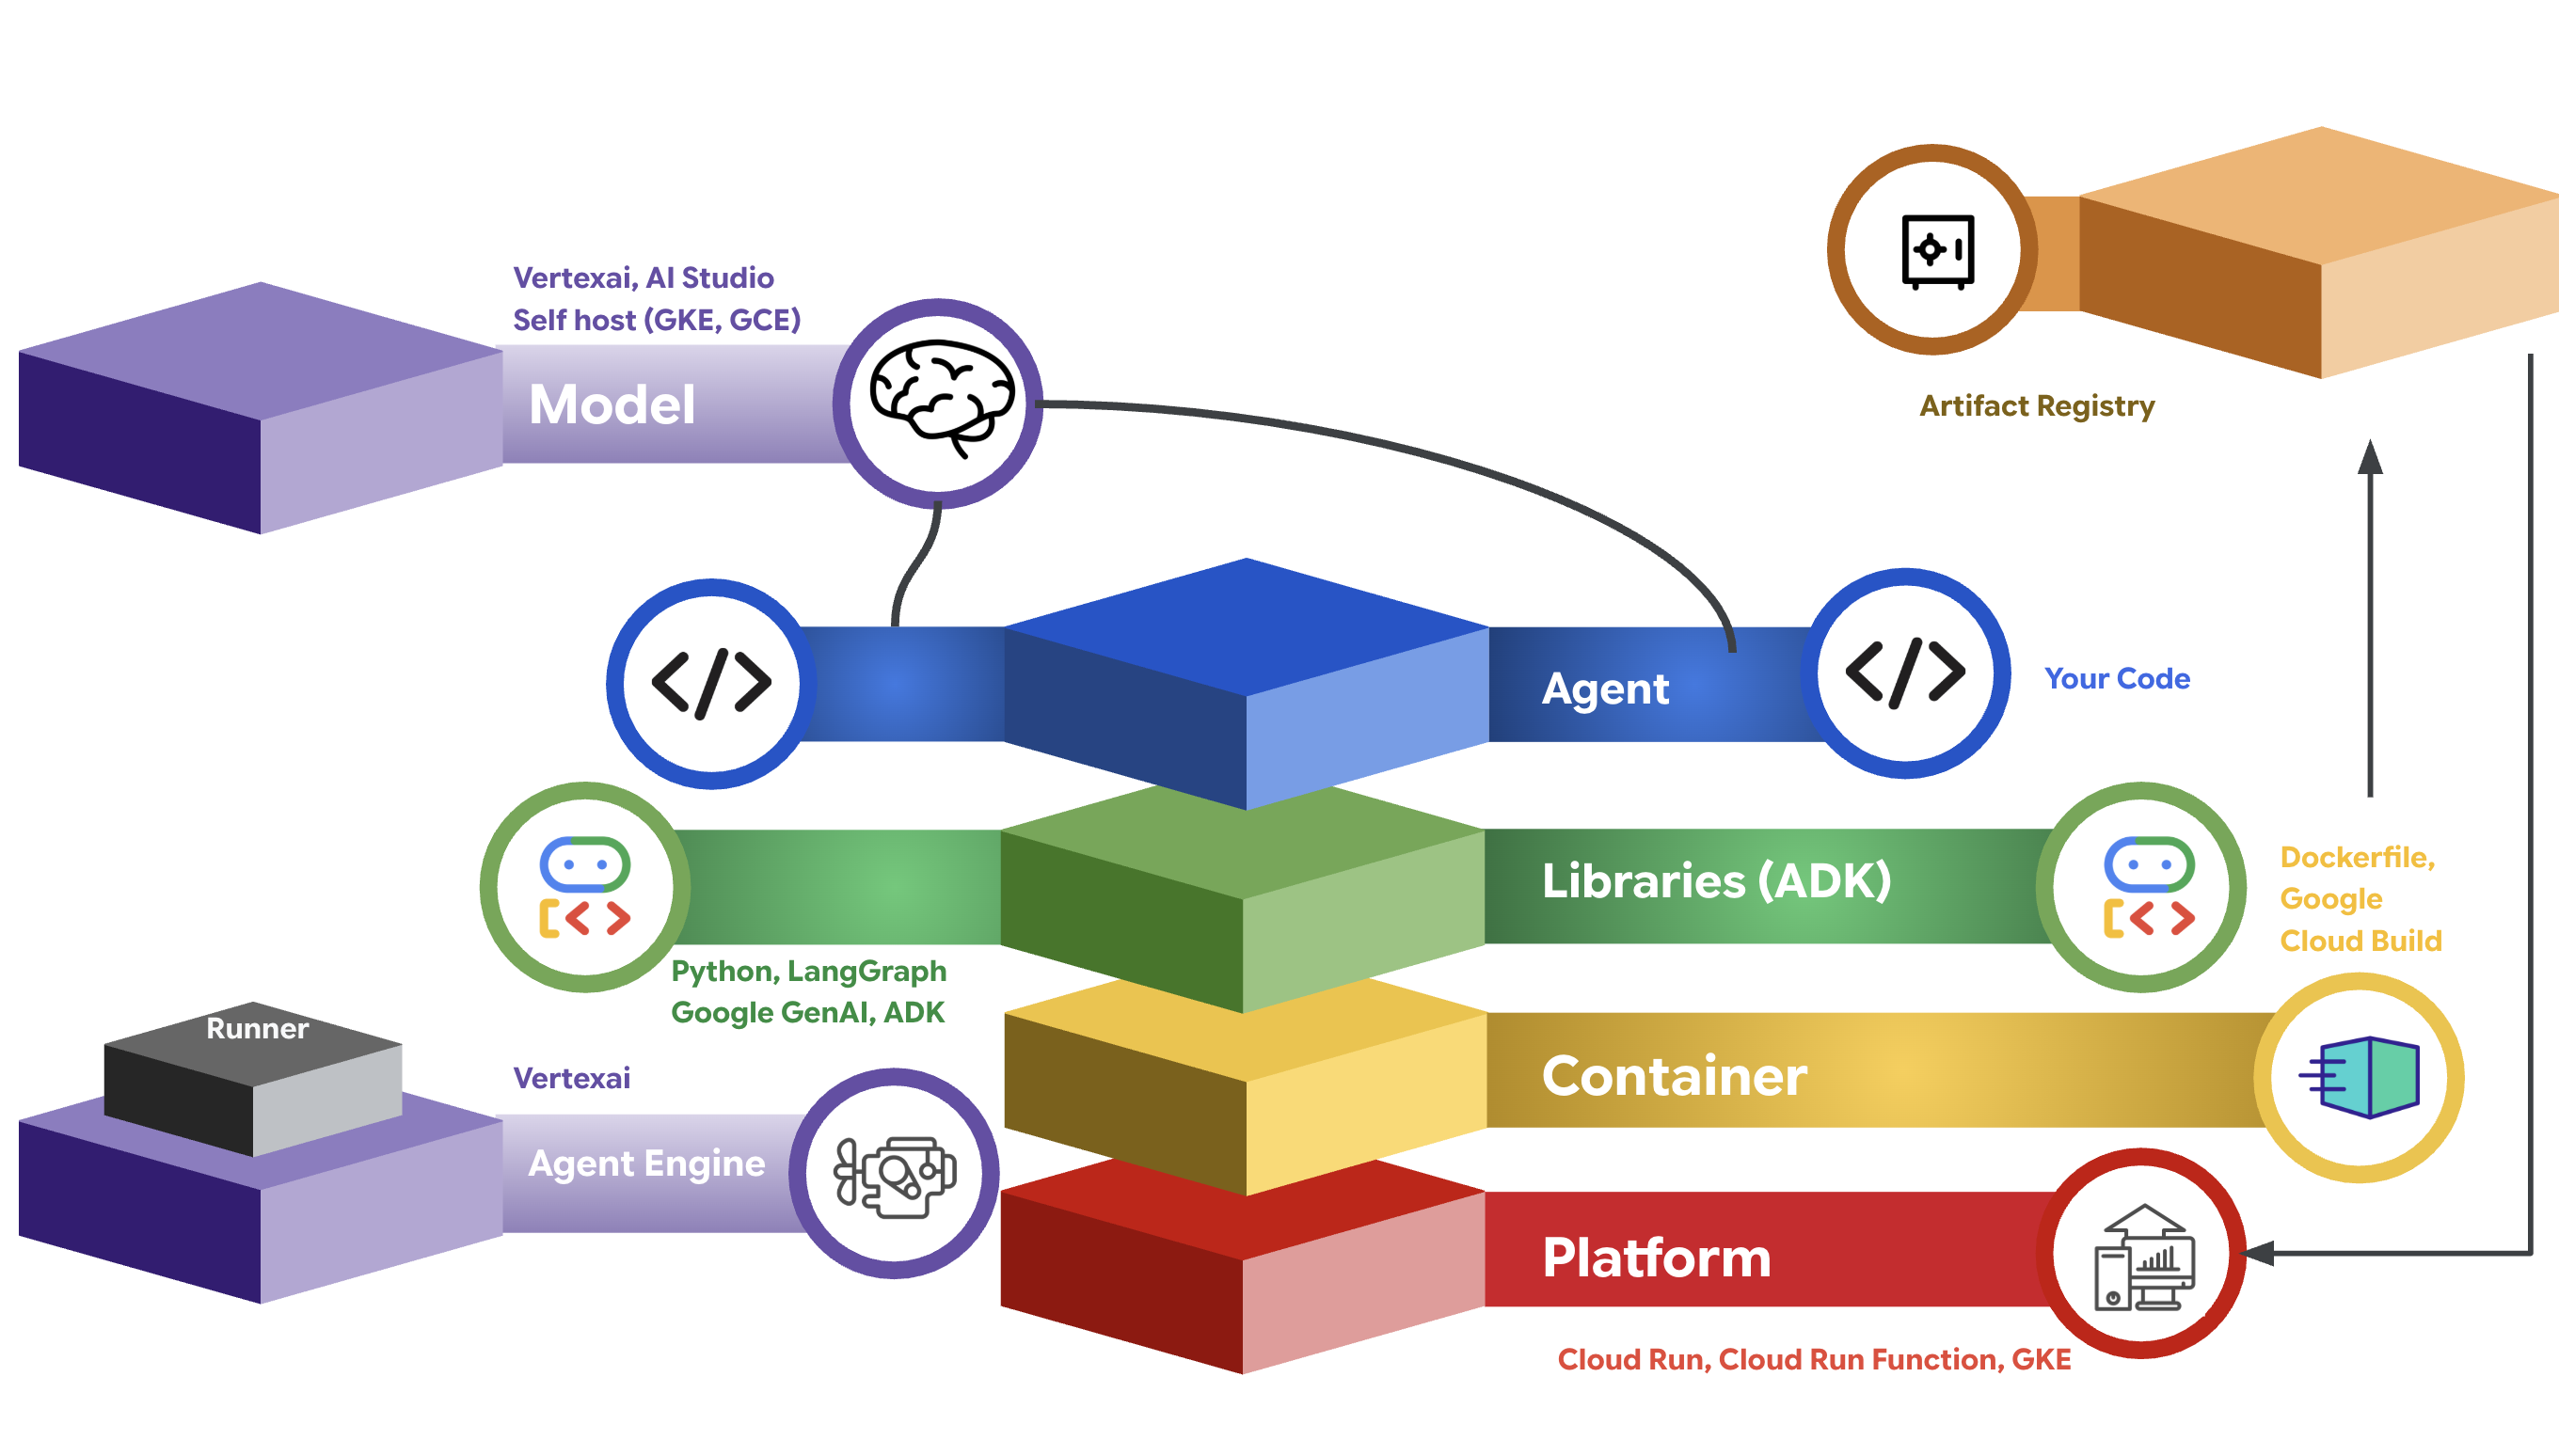

In [ ]:
import time
import vertexai
from vertexai import agent_engines
from vertexai.preview.reasoning_engines import AdkApp
from google.adk.agents import Agent
from typing import Generator, Iterable



In [ ]:
STAGING_BUCKET = "gs://adk-mini-tap" #@param {type:"string"}
project_id = os.getenv("GOOGLE_CLOUD_PROJECT")
location = os.getenv("GOOGLE_CLOUD_LOCATION")
vertexai.init(
    project=project_id,
    location=location,
    staging_bucket=STAGING_BUCKET,
)

In [ ]:
# VertexAI SDK の AdkApp クラスでエージェントをラップする
app = AdkApp(agent=weather_agent, enable_tracing=True)

In [ ]:
remote_agent = agent_engines.create(
    app,
    requirements=[
            "google-adk (==1.1.0)",
            "google-cloud-aiplatform[agent_engines] (==1.95.0)",
            "google-genai (>=1.9.0,<2.0.0)",
            "pydantic (>=2.10.6,<3.0.0)",
            "absl-py (>=2.2.1,<3.0.0)",
            "python-dotenv (>=1.0.1,<2.0.0)"
    ],
    display_name="Weather Agent 1.0",
    description="Agent Engine workshop sample",
)



INFO:vertexai.agent_engines:Identified the following requirements: {'pydantic': '2.11.4', 'google-cloud-aiplatform': '1.95.0', 'cloudpickle': '3.1.1'}
INFO:vertexai.agent_engines:The following requirements are appended: {'cloudpickle==3.1.1'}
INFO:vertexai.agent_engines:The final list of requirements: ['google-adk (==1.1.0)', 'google-cloud-aiplatform[agent_engines] (==1.95.0)', 'google-genai (>=1.9.0,<2.0.0)', 'pydantic (>=2.10.6,<3.0.0)', 'absl-py (>=2.2.1,<3.0.0)', 'python-dotenv (>=1.0.1,<2.0.0)', 'cloudpickle==3.1.1']
INFO:vertexai.agent_engines:Using bucket adk-mini-tap
INFO:vertexai.agent_engines:Wrote to gs://adk-mini-tap/agent_engine/agent_engine.pkl
INFO:vertexai.agent_engines:Writing to gs://adk-mini-tap/agent_engine/requirements.txt
INFO:vertexai.agent_engines:Creating in-memory tarfile of extra_packages
INFO:vertexai.agent_engines:Writing to gs://adk-mini-tap/agent_engine/dependencies.tar.gz
INFO:vertexai.agent_engines:Creating AgentEngine
INFO:vertexai.agent_engines:Create

In [ ]:
initial_state = {"user_preference_temperature_unit": "Celsius"}
session = remote_agent.create_session(
    user_id="example_user",
    state=initial_state
)
session_id = session["id"]

In [ ]:
for event in remote_agent.stream_query(
    user_id="example_user",
    session_id=session_id,
    message="ロンドンの天気はどうですか?",
):

    # Attempt to parse the event as a dictionary based on observed log structure
    if isinstance(event, dict):
        content = event.get("content")
        if isinstance(content, dict):
            parts = content.get("parts")
            if isinstance(parts, list):
                for part_item in parts:
                    if isinstance(part_item, dict):
                        text_content = part_item.get("text")
                        if isinstance(text_content, str) and text_content:
                            print(text_content, end="")
    # Add back the original checks as a fallback, in case some events are objects
    # This is less likely given the logs, but provides a safety net.
    elif hasattr(event, "text") and event.text:
        print(event.text, end="")
    elif hasattr(event, "content") and event.content and \
          hasattr(event.content, "parts") and event.content.parts:
        for part_item_obj in event.content.parts:
            if hasattr(part_item_obj, "text") and part_item_obj.text:
                print(part_item_obj.text, end="")

ロンドンは曇りで、気温は15℃です。

In [ ]:
for remote_agent in agent_engines.list():
  print(remote_agent.resource_name)

projects/1017461389635/locations/us-central1/reasoningEngines/1528734578980683776


In [ ]:
# 削除
for remote_agent in agent_engines.list():
  remote_agent.delete(force=True)

INFO:vertexai.agent_engines:Delete Agent Engine backing LRO: projects/1017461389635/locations/us-central1/operations/7595885198982512640
INFO:vertexai.agent_engines:Agent Engine deleted. Resource name: projects/1017461389635/locations/us-central1/reasoningEngines/1528734578980683776




---


## まとめ：あなたのエージェントチームは準備万端です！
おめでとうございます！基本的な単一の天気エージェントの構築から、エージェント開発キット（ADK）を使用した洗練されたマルチエージェントチームの構築まで、見事にやり遂げました。
**達成したことのまとめ：**
- 単一のツール（）を備えた**基本的なエージェント**から始めました。 `get_weather`
- 専門のサブエージェント（`greeting_agent`、`farewell_agent`）を作成し、ルートエージェントからの**自動委任**を有効にすることで、**モジュール性**を取り入れました。
- **セッション状態**を使用してエージェントに**メモリ**を与え、ユーザー設定（`temperature_unit`）や過去の対話（`output_key`）を記憶できるようにしました。
- `before_model_callback`（特定の入力キーワードをブロック）と `before_tool_callback`（「Paris」のような都市などの引数に基づいてツールの実行をブロック）の両方を使用して、重要な**安全ガードレール**を実装しました。

この進歩的な天気ボットチームを構築することで、複雑でインテリジェントなアプリケーションを開発するために不可欠なコア ADK の概念について実践的な経験を積むことができました。
**重要なポイント：**
- **エージェントとツール：** 機能と推論を定義するための基本的な構成要素。明確な指示とドキュメント文字列が最も重要です。
- **ランナーとセッションサービス：** エージェントの実行を調整し、会話のコンテキストを維持するエンジンとメモリ管理システム。
- **委任：** マルチエージェントチームを設計することで、専門化、モジュール性、および複雑なタスクのより良い管理が可能になります。エージェントの `description` は自動フローの鍵です。
- **セッション状態（`ToolContext`、`output_key`）：** コンテキストを認識し、パーソナライズされた、複数ターンの会話型エージェントを作成するために不可欠です。
- **コールバック（`before_model`、`before_tool`）：** 重要な操作（LLM 呼び出しまたはツール実行）の_前に_、安全性、検証、ポリシー適用、および動的な変更を実装するための強力なフック。
- **柔軟性（`LiteLlm`）：** ADK を使用すると、パフォーマンス、コスト、および機能のバランスを取りながら、ジョブに最適な LLM を選択できます。

**次のステップは？**
あなたの天気ボットチームは素晴らしい出発点です。ADK をさらに探求し、アプリケーションを強化するためのアイデアをいくつか紹介します。

1. **より複雑な状態：** より多くのユーザー設定（優先場所、通知設定など）や会話の要約をセッション状態、Memory Bankなどに保存します。
2. **委任の改良：** さまざまなルートエージェントの指示やサブエージェントの説明を試して、委任ロジックを微調整します。「予報」エージェントを追加できますか？
3. **高度なコールバック：**
    - 生成された_後に_ LLM の応答を再フォーマットまたはサニタイズするために `after_model_callback` を使用します。
    - ツールによって返された結果を処理またはログに記録するために `after_tool_callback` を使用します。
    - エージェントレベルのエントリ/終了ロジックのために `before_agent_callback` または `after_agent_callback` を実装します。

4. **エラー処理：** エージェントがツールエラーや予期しない API 応答を処理する方法を改善します。ツール内に再試行ロジックを追加することもできます。
5. **永続的なセッションストレージ：** セッション状態を永続的に保存するために `InMemorySessionService` の代替手段を検討します（Firestore や Cloud SQL などのデータベースを使用するなど。カスタム実装または将来の ADK 統合が必要です）。
6. **ストリーミング UI：** エージェントチームを Web フレームワーク（ADK ストリーミングクイックスタートで示されている FastAPI など）と統合して、リアルタイムチャットインターフェイスを作成します。

Agent Development Kitは、洗練された LLM を活用したアプリケーションを構築するための堅牢な基盤を提供します。このチュートリアルで説明した概念（ツール、状態、委任、コールバック）を習得することで、ますます複雑化するエージェントシステムに取り組むための準備が整います。
